In [1]:
import os, glob
import math
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import scipy.stats as stats
import string
from matplotlib.transforms import Bbox

RESULTS_DIR = 'results'
FIGURES_DIR = 'figs'
if not os.path.exists(FIGURES_DIR):
    os.mkdir(FIGURES_DIR)

In [2]:
def fetch_results(dep_var, level, covars=False, glass_ceiling=False, user_controlled=False,
                  top_removed=False, cajun_creole_removed=False, results_dir=RESULTS_DIR):
    """
    @param dep_var: the dependent variable regression to fetch
    @param level: `macro`, `region`, or `cuisine`
    @param covars: if True, return covariance matrix
    @param exclude_neg: if True, exclude frames under scope of negation
    @param glass_ceiling: if True, fetch glass ceiling results
    @param user_controlled: if True, fetch user-controlled results
    @param top_removed: if True, fetch results with top-cuisine removed
    """
    
    savename = f"{dep_var}_{level}"
    if covars:
        savename = f"{savename}_covars"
    if glass_ceiling:
        savename = f"glass_ceiling_{savename}"
    if user_controlled:
        savename = f"user_cont_{savename}"
    if top_removed:
        savename = f"top_removed_{savename}"
    if cajun_creole_removed:
        savename = f"cajun-creole_removed_{savename}"
        
    res = pd.read_csv(os.path.join(results_dir, savename+".csv"), index_col=0)
    
    return res

In [3]:
def get_abs_coeffs(res, per_cuisine=False, ref='us'):
    try:
        intercept = res.iloc[0]['coef']
        coef_col = 'coef'
    except KeyError:
        intercept = res.iloc[0]['Coef.']
        coef_col = 'Coef.'
    if per_cuisine:
        cuisine_coeffs = res[coef_col].filter(like='biz_cuisine',axis=0)
        cuisine_coeffs.index = [x.replace('biz_cuisine_','') for x in cuisine_coeffs.index]
    else:
        cuisine_coeffs = res[coef_col].filter(like='_region', axis=0)
        cuisine_coeffs.index = [x.split('T.')[-1].replace(']','') for x in cuisine_coeffs.index]
    cuisine_coeffs = cuisine_coeffs + intercept
    cuisine_coeffs = cuisine_coeffs.to_dict()
    cuisine_coeffs[ref] = intercept
    return cuisine_coeffs

def get_standard_error_sum(results, covariates):
    '''
    #95CI is approximated with +- 2 sum_variance_standard_error
    '''
    # get the variance covariance matrix
    # print(covariates)
    vcov = results.loc[covariates, covariates].values

    # calculate the sum of all pair wise covariances by summing up off-diagonal entries
    off_dia_sum = np.sum(vcov)
    # variance of a sum of variables is the square root
    return np.sqrt(off_dia_sum)

def get_abs_errs(res, covar_res, per_cuisine=False, ref='us'):
    abs_errs_per_coeff = {}
    intercept_name = covar_res.iloc[0].index[0]
    if per_cuisine:
        coeff_names = covar_res.filter(like='biz_cuisine',axis=0).index
    else:
        coeff_names = covar_res.filter(like='_region',axis=0).index
    for coeff in coeff_names:
        covariates = [intercept_name] + [coeff]
        err = get_standard_error_sum(covar_res, covariates)
        if per_cuisine:
            pretty_coeff = coeff.split('_')[-1]
        else:
            pretty_coeff = coeff.split('T.')[-1].replace(']','')
        abs_errs_per_coeff[pretty_coeff] = err
    try:
        abs_errs_per_coeff[ref] = res['std err'][intercept_name]
    except KeyError:
        abs_errs_per_coeff[ref] = res['Std.Err.'][intercept_name]
    return abs_errs_per_coeff

def get_pvalues(res, per_cuisine=False, ref='us'):
    if per_cuisine:
        pvals = res.pvalues.filter(like='biz_cuisine',axis=0)
        pvals.index = [x.replace('biz_cuisine_','') for x in pvals.index]
        pvals = pvals.to_dict()
    else:
        pvals = {ref: res.pvalues[0]}
        for region_coeff in res.params.filter(like='_region',axis=0).index:
            pvals[region_coeff.split('T.')[-1].replace(']','')] = res.pvalues[region_coeff]
    return pvals

def mark_significance(s, pval):
    if pval < 0.0001:
        return s+'****'
    elif pval < 0.001:
        return s+'***'
    elif pval < 0.01:
        return s+'**'
    elif pval < 0.05:
        return s+'*'
    else:
        return s
    
def prettify_dep_var(dep_var):
    if 'liwc_posemo' in dep_var:
        return 'Positivity'
    if 'luxury' in dep_var:
        return 'Luxury'
    if 'auth_simple' in dep_var:
        return 'Authenticity-simplicity'
    if 'auth_other' in dep_var:
        return 'Authenticity-other'
    if 'auth' in dep_var:
        return 'Authenticity'
    if 'politeness_pos' in dep_var:
        return 'Polite'
    if 'politeness_neg' in dep_var:
        return 'Rudeness'
    if 'polite' in dep_var:
        return 'Politeness'
    if 'hygiene_words' in dep_var:
        return 'Hygiene'
    if 'hygiene_pos_words' in dep_var:
        return 'Clean'
    if 'hygiene_neg_words' in dep_var:
        return 'Dirty'
    if 'taste_smell_words' in dep_var:
        return 'Concrete taste/smell'
    if 'taste_smell_pos' in dep_var:
        return 'Positive taste/smell'
    if 'taste_smell_neut' in dep_var:
        return 'Neutral taste/smell'
    if 'taste_smell_neg' in dep_var:
        return 'Negative taste/smell'
    if 'exotic_pos' in dep_var:
        return 'Exoticity-pos'
    if 'exotic_neg' in dep_var:
        return 'Exoticism-neg'
    if 'exotic_neut' in dep_var:
        return 'Exoticism-neut'
    if 'exotic' in dep_var:
        return 'Exoticism'
    if 'typic_pos' in dep_var:
        return 'Prototypicality-pos'
    if 'typic_neg' in dep_var:
        return 'Prototypicality-neg'
    if 'typic' in dep_var:
        return 'Prototypicality'
    if 'negemo' in dep_var:
        return 'Negativity'
    if 'cheapness_exp' in dep_var:
        return 'Expensive'
    if 'cheapness_cheap' in dep_var:
        return 'Cheap'
    if 'cheapness_words' in dep_var:
        return 'Cost'
    
def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)
    
cont2color = {
    'asia':'firebrick',
    'europe':'slateblue',
    'eur':'cornflowerblue',
    'us':'navy',
    'latin_america':'cadetblue',
    'lat':'mediumseagreen',
    'middle_east': 'darkorange',
    'fusion':'darkviolet',
    'non-us':'firebrick'}

country2abbrev = {
    'chinese':'ch',
    'mexican':'mx',
    'thai':'th',
    'vietnamese':'vt',
    'indian':'in',
    'korean':'ko',
    'latin american':'la',
    'middle eastern':'mid',
    'mediterranean':'med',
    'irish':'ir',
    'japanese':'jp',
    'asian fusion':'as',
    'greek':'gr',
    'soul food':'sf',
    'french':'fr',
    'tex-mex':'tx',
    'cajun/creole':'caj',
    'italian':'it',
    'southern':'so',
    'caribbean':'car',
    'spanish':'sp',
    'cuban':'cu',
    'american (traditional)':'us.old',
    'american (new)':'us.new'}
abbrev2country = dict(zip(country2abbrev.values(), country2abbrev.keys()))

In [4]:
cuisine2macro_region = {'us':'us', 'asia':'non-us', 'latin_america':'non-us', 'europe':'non-us'}

ethnic_cats_per_continent = pd.read_csv('../ethnic_cats_per_continent.csv')
ethnic_cat2continent = dict(zip(ethnic_cats_per_continent['cuisine'],ethnic_cats_per_continent['region']))
ethnic_cats_per_continent.sort_values('region').set_index(['region'])

,cuisine
region,
-1,ethnic food
-1,canadian (new)
-1,international
africa,ethiopian
africa,moroccan
...,...
us,new american
us,traditional american
us,american


# Study 1: Othering

Will save figure to: figs/study1_main_results.pdf


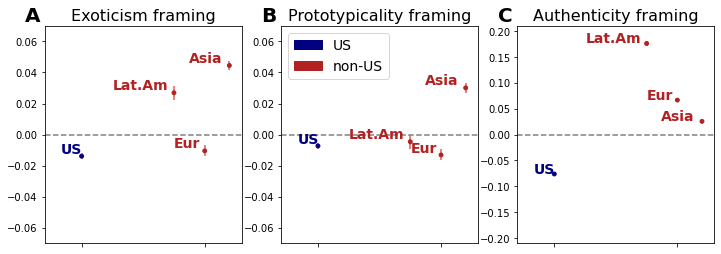

In [5]:
# Study 1 main results

fig_name = 'study1_main_results' # set name without file extension
assert type(fig_name) == str
print("Will save figure to:", os.path.join(FIGURES_DIR, f"{fig_name}.pdf"))

dep_vars_to_plot = ['exotic_words_agg_score',
                    'typic_words_agg_score',
                    'auth_words_agg_score']

fig, axs = plt.subplots(1,3,figsize=(12,4),sharey=False,sharex=True)

macro_coeff_ticks = ['us','non-us']
pretty_macro_coeff_ticks = ['US','non-US']
region_coeff_ticks = ['us','europe','latin_america','asia']
pretty_region_coeff_ticks = ['US','Eur','Lat.Am','Asia']

coeff2x_val = {
    'exotic_words_agg_score': {'us': 0, 'europe': 1, 'latin_america':1-0.25, 'asia':1+0.2},
    'auth_words_agg_score': {'us': 0, 'europe': 1, 'latin_america':1-0.25, 'asia':1+0.2},
    'typic_words_agg_score': {'us': 0, 'europe': 1, 'latin_america':1-0.25, 'asia':1+0.2},}

for ax_ix,dep_var in enumerate(dep_vars_to_plot):

    # get results from .csvs
    res = fetch_results(dep_var, 'biz_cuisine_region')
    covar_res = fetch_results(dep_var, 'biz_cuisine_region', covars=True)
    per_region_coeffs = get_abs_coeffs(res, per_cuisine=False)
    per_region_errs = get_abs_errs(res, covar_res, per_cuisine=False)

    # Overall parameters
    ax = axs[ax_ix]
    ax.axhline(y=0, color="gray", linestyle="--")
    ax.set_xticks(range(len(macro_coeff_ticks)))
    ax.set_xticklabels([])
    ax.set_xlim(-0.3,1.3)
    
    if ax_ix < 2:
        ax.set_ylim(-.07,.07)
    else:
        ax.set_ylim(-.21,.21)

    # Plot coefficients
    ax.scatter([coeff2x_val[dep_var][x] for x in region_coeff_ticks],
               [per_region_coeffs[x] for x in region_coeff_ticks], 
               color=[cont2color[cuisine2macro_region[x]] for x in region_coeff_ticks], 
               zorder=2,s=15)

    # Plot errors
    for idx, coeff in enumerate(region_coeff_ticks):
        color = "lightcoral" #if pvals[coeff] < 0.05 else 'lightgray'
        ax.vlines(coeff2x_val[dep_var][coeff], 
                  per_region_coeffs[coeff]-2*per_region_errs[coeff], 
                  per_region_coeffs[coeff]+2*per_region_errs[coeff], 
                  color=color, 
                  zorder=1, linewidth=2)

    # Add labels
    for idx, coeff in enumerate(region_coeff_ticks):
        offset = len(pretty_region_coeff_ticks[idx])*.083
        ax.annotate(pretty_region_coeff_ticks[idx], 
                    (coeff2x_val[dep_var][coeff]-offset, per_region_coeffs[coeff]+0.002), 
                    color=cont2color[cuisine2macro_region[coeff]],
                    fontsize=14, weight="bold")

    # Add titles 
    ax.set_title(f"{prettify_dep_var(dep_var)} framing",fontsize=16)
    ax.text(-0.1, 1.02, string.ascii_uppercase[ax_ix], transform=ax.transAxes, 
            size=20, weight='bold')
    
    # Add legend to first subplot
    if ax_ix == 1:
        us_patch = mpatches.Patch(color=cont2color['us'], label='US')
        non_us_patch = mpatches.Patch(color=cont2color['non-us'], label='non-US')
        ax.legend(handles=[us_patch, non_us_patch], fontsize=14, loc='upper left')
    
#     # Save just the portion _inside_ the second axis's boundaries
#     extent = full_extent(ax).transformed(fig.dpi_scale_trans.inverted())
#     # Alternatively,
#     # extent = ax.get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
#     print("Saving subplot to:", os.path.join(FIGURES_DIR, f"{fig_name}_subplot{ax_ix}.pdf"))
#     fig.savefig(os.path.join(FIGURES_DIR, f"{fig_name}_subplot{ax_ix}.pdf"), bbox_inches=extent)
plt.savefig(os.path.join(FIGURES_DIR, f"{fig_name}.pdf"),bbox_inches="tight")
plt.show()

In [6]:
# Macro-region results
res = fetch_results('exotic_words_agg_score', 'biz_macro_region')
display(res)
print(res['P>|t|']["C(biz_macro_region, Treatment(reference='us'))[T.non-us]"])
res = fetch_results('typic_words_agg_score', 'biz_macro_region')
display(res)
print(res['P>|t|']["C(biz_macro_region, Treatment(reference='us'))[T.non-us]"])
res = fetch_results('auth_words_agg_score', 'biz_macro_region')
display(res)
print(res['P>|t|']["C(biz_macro_region, Treatment(reference='us'))[T.non-us]"])

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.0133,0.001,-13.192,0.000,-0.015,-0.011
"C(biz_macro_region, Treatment(reference='us'))[T.non-us]",0.0351,0.001,24.853,0.000,0.032,0.038
"C(biz_price_point, Treatment(reference=2))[T.1]",-0.0221,0.002,-10.523,0.000,-0.026,-0.018
"C(biz_price_point, Treatment(reference=2))[T.3]",-0.0060,0.003,-2.288,0.022,-0.011,-0.001
"C(biz_price_point, Treatment(reference=2))[T.4]",0.0024,0.009,0.267,0.789,-0.016,0.020
review_len,0.1779,0.001,256.443,0.000,0.177,0.179
biz_mean_star_rating,0.0072,0.001,10.405,0.000,0.006,0.009
biz_median_nb_income,-0.0002,0.001,-0.211,0.833,-0.002,0.001
biz_nb_diversity,0.0006,0.001,0.664,0.506,-0.001,0.002


0.0


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.0067,0.001,-6.645,0.0,-0.009,-0.005
"C(biz_macro_region, Treatment(reference='us'))[T.non-us]",0.0147,0.001,10.394,0.0,0.012,0.017
"C(biz_price_point, Treatment(reference=2))[T.1]",0.0326,0.002,15.526,0.0,0.028,0.037
"C(biz_price_point, Treatment(reference=2))[T.3]",-0.0531,0.003,-20.149,0.0,-0.058,-0.048
"C(biz_price_point, Treatment(reference=2))[T.4]",-0.0648,0.009,-7.074,0.0,-0.083,-0.047
review_len,0.1773,0.001,255.670,0.0,0.176,0.179
biz_mean_star_rating,-0.0242,0.001,-34.831,0.0,-0.026,-0.023
biz_median_nb_income,0.0087,0.001,10.372,0.0,0.007,0.010
biz_nb_diversity,-0.0035,0.001,-4.217,0.0,-0.005,-0.002


0.0


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.0777,0.001,-77.287,0.0,-0.080,-0.076
"C(biz_macro_region, Treatment(reference='us'))[T.non-us]",0.1482,0.001,105.026,0.0,0.145,0.151
"C(biz_price_point, Treatment(reference=2))[T.1]",0.1031,0.002,49.161,0.0,0.099,0.107
"C(biz_price_point, Treatment(reference=2))[T.3]",-0.0614,0.003,-23.326,0.0,-0.067,-0.056
"C(biz_price_point, Treatment(reference=2))[T.4]",-0.1136,0.009,-12.423,0.0,-0.132,-0.096
review_len,0.1609,0.001,232.211,0.0,0.160,0.162
biz_mean_star_rating,0.0512,0.001,73.837,0.0,0.050,0.053
biz_median_nb_income,0.0072,0.001,8.540,0.0,0.006,0.009
biz_nb_diversity,0.0035,0.001,4.174,0.0,0.002,0.005


0.0


In [7]:
# Authenticity simplicity results
res = fetch_results('auth_simple_words_agg_score', 'biz_cuisine_region')
display(res)
res = fetch_results('auth_other_words_agg_score', 'biz_cuisine_region')
display(res)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.0124,0.001,-12.191,0.000,-0.014,-0.010
"C(biz_cuisine_region, Treatment(reference='us'))[T.asia]",-0.0528,0.002,-28.681,0.000,-0.056,-0.049
"C(biz_cuisine_region, Treatment(reference='us'))[T.europe]",0.0885,0.002,44.615,0.000,0.085,0.092
"C(biz_cuisine_region, Treatment(reference='us'))[T.latin_america]",0.0340,0.002,14.153,0.000,0.029,0.039
"C(biz_price_point, Treatment(reference=2))[T.1]",0.0599,0.002,27.995,0.000,0.056,0.064
"C(biz_price_point, Treatment(reference=2))[T.3]",-0.0275,0.003,-10.309,0.000,-0.033,-0.022
"C(biz_price_point, Treatment(reference=2))[T.4]",-0.0998,0.009,-10.813,0.000,-0.118,-0.082
review_len,0.1161,0.001,166.014,0.000,0.115,0.117
biz_mean_star_rating,0.0412,0.001,58.792,0.000,0.040,0.043
biz_median_nb_income,0.0128,0.001,15.079,0.000,0.011,0.014


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.0890,0.001,-88.092,0.000,-0.091,-0.087
"C(biz_cuisine_region, Treatment(reference='us'))[T.asia]",0.1736,0.002,94.738,0.000,0.170,0.177
"C(biz_cuisine_region, Treatment(reference='us'))[T.europe]",0.1155,0.002,58.485,0.000,0.112,0.119
"C(biz_cuisine_region, Treatment(reference='us'))[T.latin_america]",0.3006,0.002,125.728,0.000,0.296,0.305
"C(biz_price_point, Treatment(reference=2))[T.1]",0.0638,0.002,29.950,0.000,0.060,0.068
"C(biz_price_point, Treatment(reference=2))[T.3]",-0.0596,0.003,-22.388,0.000,-0.065,-0.054
"C(biz_price_point, Treatment(reference=2))[T.4]",-0.0680,0.009,-7.406,0.000,-0.086,-0.050
review_len,0.1174,0.001,168.649,0.000,0.116,0.119
biz_mean_star_rating,0.0341,0.001,48.907,0.000,0.033,0.035
biz_median_nb_income,0.0005,0.001,0.532,0.595,-0.001,0.002


Will save figure to: figs/study1_per_cuisine_results.pdf


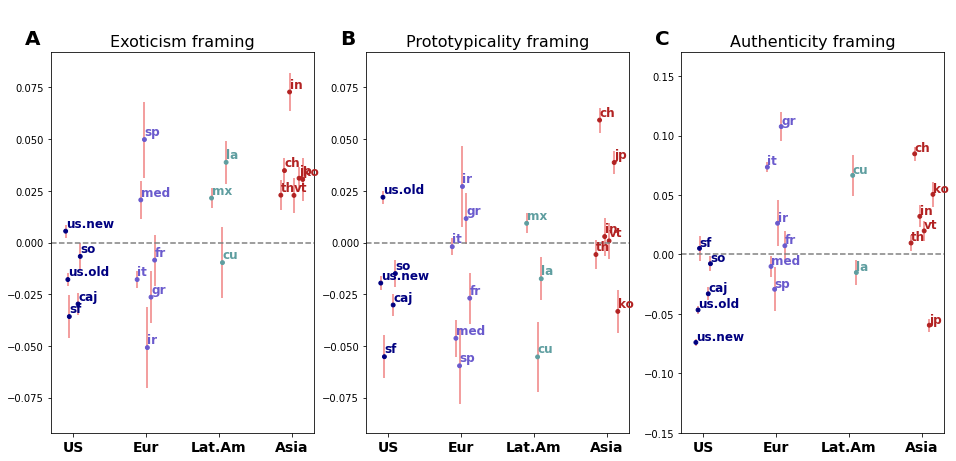

In [10]:
# Study 1 per cuisine results

fig_name = 'study1_per_cuisine_results' # set name without file extension
assert type(fig_name) == str
print("Will save figure to:", os.path.join(FIGURES_DIR, f"{fig_name}.pdf"))

dep_vars_to_plot = ['exotic_words_agg_score',
                    'typic_words_agg_score',
                    'auth_words_agg_score']

fig, axs = plt.subplots(1,3,figsize=(16,7),sharey=False,sharex=True)

macro_coeff_ticks = ['us','non-us']
pretty_macro_coeff_ticks = ['US','non-US']
region_coeff_ticks = ['us','europe','latin_america','asia']
pretty_region_coeff_ticks = ['US','Eur','Lat.Am','Asia']
cuisine_coeff_ticks = ['american (new)','american (traditional)','cajun/creole','southern','soul food',
                      'french','greek','irish','italian','mediterranean','spanish',
                      'cuban','latin american','mexican',
                      'chinese','indian','japanese','korean','thai','vietnamese']
pretty_cuisine_coeff_ticks = [country2abbrev[x] for x in cuisine_coeff_ticks]

jitter = {
    'us.new': -0.1,
    'so': .1,
    'us.old':-0.07,
    'caj':.07,
    'sf':-0.05,
    'fr':.12,
    'it':-.12,
    'med':-.07,
    'gr':.07,
    'ir':.02,
    'sp':-.02,
    'la':.1,
    'mx':-.1,
    'cu':.05,
    'ch':-0.1,
    'jp':.1,
    'in':-.03,
    'vt':.03,
    'th':-.15,
    'ko':.15}

for ax_ix,dep_var in enumerate(dep_vars_to_plot):

    # get results from .csvs
    res = fetch_results(dep_var, 'biz_cuisine')
    covar_res = fetch_results(dep_var, 'biz_cuisine', covars=True)
    per_region_coeffs = get_abs_coeffs(res, per_cuisine=True)
    per_region_errs = get_abs_errs(res, covar_res, per_cuisine=True)

    # Overall parameters
    ax = axs[ax_ix]
    ax.axhline(y=0, color="gray", linestyle="--")
    ax.set_xticks(range(len(region_coeff_ticks)))
    ax.set_xticklabels(pretty_region_coeff_ticks,fontweight='bold',fontsize=14)
    ax.set_xlim(-0.3,3.3)
    
    if ax_ix < 2:
        ax.set_ylim(-.092,.092)
    else:
        ax.set_ylim(-.15,.17)

    # Plot coefficients
    ax.scatter([region_coeff_ticks.index(ethnic_cat2continent[x])+jitter[country2abbrev[x]] for x in cuisine_coeff_ticks],
               [per_region_coeffs[x] for x in cuisine_coeff_ticks], 
               color=[cont2color[ethnic_cat2continent[x]] for x in cuisine_coeff_ticks], 
               zorder=2,s=15)

    # Plot errors
    for idx, coeff in enumerate(cuisine_coeff_ticks):
        offset = jitter[country2abbrev[coeff]]#len(pretty_cuisine_coeff_ticks[idx])*.083
        color = "lightcoral" #if pvals[coeff] < 0.05 else 'lightgray'
        ax.vlines(region_coeff_ticks.index(ethnic_cat2continent[coeff])+offset, 
                  per_region_coeffs[coeff]-2*per_region_errs[coeff], 
                  per_region_coeffs[coeff]+2*per_region_errs[coeff], 
                  color=color, 
                  zorder=1, linewidth=1.5)

    # Add labels
    for idx, coeff in enumerate(cuisine_coeff_ticks):
        offset = jitter[country2abbrev[coeff]]#len(pretty_cuisine_coeff_ticks[idx])*.083
        ax.annotate(pretty_cuisine_coeff_ticks[idx], 
                    (region_coeff_ticks.index(ethnic_cat2continent[coeff])+offset, per_region_coeffs[coeff]+0.002), 
                    color=cont2color[ethnic_cat2continent[coeff]],
                    fontsize=12, weight="bold")

    # Add titles 
    ax.set_title(f"{prettify_dep_var(dep_var)} framing",fontsize=16)
    ax.text(-0.1, 1.02, string.ascii_uppercase[ax_ix], transform=ax.transAxes, 
            size=20, weight='bold')

#     # Save just the portion _inside_ the second axis's boundaries
#     extent = full_extent(ax).transformed(fig.dpi_scale_trans.inverted())
#     # Alternatively,
#     # extent = ax.get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
#     print("Saving subplot to:", os.path.join(FIGURES_DIR, f"{fig_name}_subplot{ax_ix}.pdf"))
#     fig.savefig(os.path.join(FIGURES_DIR, f"{fig_name}_subplot{ax_ix}.pdf"), bbox_inches=extent)
    
plt.savefig(os.path.join(FIGURES_DIR, f"{fig_name}.pdf"),bbox_inches="tight")
plt.show()

Will save figure to: figs/top_removed_study1_main_results.pdf


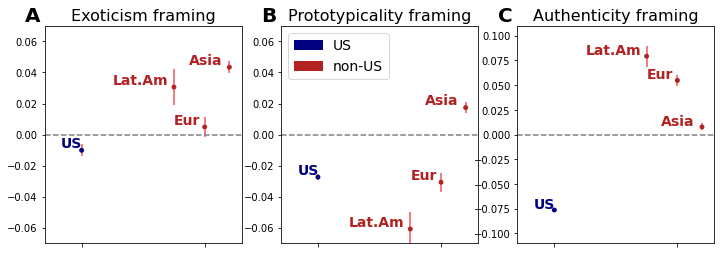

In [11]:
# Study 1 top cuisine removed

fig_name = 'top_removed_study1_main_results' # set name without file extension
assert type(fig_name) == str
print("Will save figure to:", os.path.join(FIGURES_DIR, f"{fig_name}.pdf"))

dep_vars_to_plot = ['exotic_words_agg_score',
                    'typic_words_agg_score',
                    'auth_words_agg_score']

fig, axs = plt.subplots(1,3,figsize=(12,4),sharey=False,sharex=True)

macro_coeff_ticks = ['us','non-us']
pretty_macro_coeff_ticks = ['US','non-US']
region_coeff_ticks = ['us','europe','latin_america','asia']
pretty_region_coeff_ticks = ['US','Eur','Lat.Am','Asia']

for ax_ix,dep_var in enumerate(dep_vars_to_plot):

    # get results from .csvs
    res = fetch_results(dep_var, 'biz_cuisine_region', top_removed=True)
    covar_res = fetch_results(dep_var, 'biz_cuisine_region', covars=True, top_removed=True)
    per_region_coeffs = get_abs_coeffs(res, per_cuisine=False)
    per_region_errs = get_abs_errs(res, covar_res, per_cuisine=False)

    # Overall parameters
    ax = axs[ax_ix]
    ax.axhline(y=0, color="gray", linestyle="--")
    ax.set_xticks(range(len(macro_coeff_ticks)))
    ax.set_xticklabels([])
    ax.set_xlim(-0.3,1.3)
    if ax_ix < 2:
        ax.set_ylim(-.07,.07)
    else:
        ax.set_ylim(-.11,.11)

    # Plot coefficients
    ax.scatter([coeff2x_val[dep_var][x] for x in region_coeff_ticks],
               [per_region_coeffs[x] for x in region_coeff_ticks], 
               color=[cont2color[cuisine2macro_region[x]] for x in region_coeff_ticks], 
               zorder=2,s=15)

    # Plot errors
    for idx, coeff in enumerate(region_coeff_ticks):
        color = "lightcoral" #if pvals[coeff] < 0.05 else 'lightgray'
        ax.vlines(coeff2x_val[dep_var][coeff], 
                  per_region_coeffs[coeff]-2*per_region_errs[coeff], 
                  per_region_coeffs[coeff]+2*per_region_errs[coeff], 
                  color=color, 
                  zorder=1, linewidth=2)

    # Add labels
    for idx, coeff in enumerate(region_coeff_ticks):
        offset = len(pretty_region_coeff_ticks[idx])*.083
        ax.annotate(pretty_region_coeff_ticks[idx], 
                    (coeff2x_val[dep_var][coeff]-offset, per_region_coeffs[coeff]+0.002), 
                    color=cont2color[cuisine2macro_region[coeff]],
                    fontsize=14, weight="bold")

    # Add titles 
    ax.set_title(f"{prettify_dep_var(dep_var)} framing",fontsize=16)
    ax.text(-0.1, 1.02, string.ascii_uppercase[ax_ix], transform=ax.transAxes, 
            size=20, weight='bold')
    
    # Add legend to first subplot
    if ax_ix == 1:
        us_patch = mpatches.Patch(color=cont2color['us'], label='US')
        non_us_patch = mpatches.Patch(color=cont2color['non-us'], label='non-US')
        ax.legend(handles=[us_patch, non_us_patch], fontsize=14, loc='upper left')
        
#     # Save just the portion _inside_ the second axis's boundaries
#     extent = full_extent(ax).transformed(fig.dpi_scale_trans.inverted())
#     # Alternatively,
#     # extent = ax.get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
#     print("Saving subplot to:", os.path.join(FIGURES_DIR, f"{fig_name}_subplot{ax_ix}.pdf"))
#     fig.savefig(os.path.join(FIGURES_DIR, f"{fig_name}_subplot{ax_ix}.pdf"), bbox_inches=extent)
    
plt.savefig(os.path.join(FIGURES_DIR, f"{fig_name}.pdf"),bbox_inches="tight")
plt.show()

Will save figure to: figs/cajun-creole_removed_study1_main_results.pdf


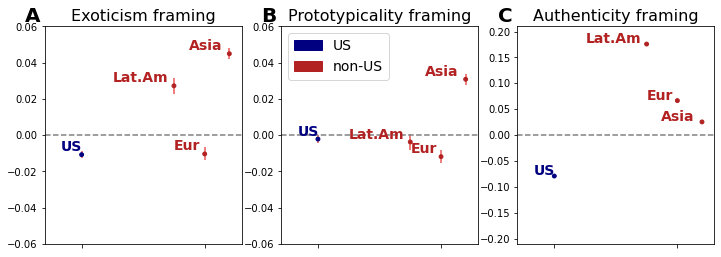

In [12]:
# Study 1 cajun/creole removed

fig_name = 'cajun-creole_removed_study1_main_results' # set name without file extension
assert type(fig_name) == str
print("Will save figure to:", os.path.join(FIGURES_DIR, f"{fig_name}.pdf"))

dep_vars_to_plot = ['exotic_words_agg_score',
                    'typic_words_agg_score',
                    'auth_words_agg_score']

fig, axs = plt.subplots(1,3,figsize=(12,4),sharey=False,sharex=True)

macro_coeff_ticks = ['us','non-us']
pretty_macro_coeff_ticks = ['US','non-US']
region_coeff_ticks = ['us','europe','latin_america','asia']
pretty_region_coeff_ticks = ['US','Eur','Lat.Am','Asia']

for ax_ix,dep_var in enumerate(dep_vars_to_plot):

    # get results from .csvs
    res = fetch_results(dep_var, 'biz_cuisine_region', cajun_creole_removed=True)
    covar_res = fetch_results(dep_var, 'biz_cuisine_region', covars=True, cajun_creole_removed=True)
    per_region_coeffs = get_abs_coeffs(res, per_cuisine=False)
    per_region_errs = get_abs_errs(res, covar_res, per_cuisine=False)

    # Overall parameters
    ax = axs[ax_ix]
    ax.axhline(y=0, color="gray", linestyle="--")
    ax.set_xticks(range(len(macro_coeff_ticks)))
    ax.set_xticklabels([])
    ax.set_xlim(-0.3,1.3)
    if ax_ix < 2:
        ax.set_ylim(-.06,.06)
    else:
        ax.set_ylim(-.21,.21)

    # Plot coefficients
    ax.scatter([coeff2x_val[dep_var][x] for x in region_coeff_ticks],
               [per_region_coeffs[x] for x in region_coeff_ticks], 
               color=[cont2color[cuisine2macro_region[x]] for x in region_coeff_ticks], 
               zorder=2,s=15)

    # Plot errors
    for idx, coeff in enumerate(region_coeff_ticks):
        color = "lightcoral" #if pvals[coeff] < 0.05 else 'lightgray'
        ax.vlines(coeff2x_val[dep_var][coeff], 
                  per_region_coeffs[coeff]-2*per_region_errs[coeff], 
                  per_region_coeffs[coeff]+2*per_region_errs[coeff], 
                  color=color, 
                  zorder=1, linewidth=2)

    # Add labels
    for idx, coeff in enumerate(region_coeff_ticks):
        offset = len(pretty_region_coeff_ticks[idx])*.083
        ax.annotate(pretty_region_coeff_ticks[idx], 
                    (coeff2x_val[dep_var][coeff]-offset, per_region_coeffs[coeff]+0.002), 
                    color=cont2color[cuisine2macro_region[coeff]],
                    fontsize=14, weight="bold")

    # Add titles 
    ax.set_title(f"{prettify_dep_var(dep_var)} framing",fontsize=16)
    ax.text(-0.1, 1.02, string.ascii_uppercase[ax_ix], transform=ax.transAxes, 
            size=20, weight='bold')
    
    # Add legend to first subplot
    if ax_ix == 1:
        us_patch = mpatches.Patch(color=cont2color['us'], label='US')
        non_us_patch = mpatches.Patch(color=cont2color['non-us'], label='non-US')
        ax.legend(handles=[us_patch, non_us_patch], fontsize=14, loc='upper left')
        
#     # Save just the portion _inside_ the second axis's boundaries
#     extent = full_extent(ax).transformed(fig.dpi_scale_trans.inverted())
#     # Alternatively,
#     # extent = ax.get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
#     print("Saving subplot to:", os.path.join(FIGURES_DIR, f"{fig_name}_subplot{ax_ix}.pdf"))
#     fig.savefig(os.path.join(FIGURES_DIR, f"{fig_name}_subplot{ax_ix}.pdf"), bbox_inches=extent)
    
plt.savefig(os.path.join(FIGURES_DIR, f"{fig_name}.pdf"),bbox_inches="tight")
plt.show()

Will save figure to: figs/study1_user_cont_results.pdf


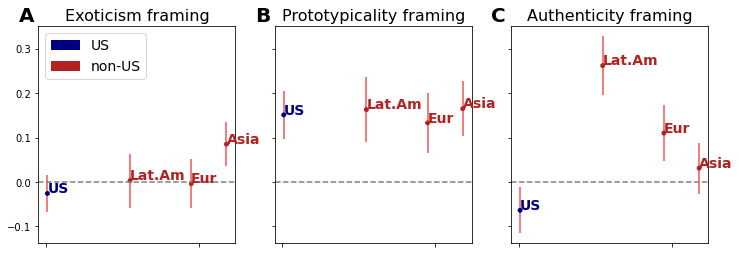

In [13]:
# Study 1: user-controlled results

fig_name = 'study1_user_cont_results' # set name without file extension
assert type(fig_name) == str
print("Will save figure to:", os.path.join(FIGURES_DIR, f"{fig_name}.pdf"))

dep_vars_to_plot = ['exotic_words_agg_score',
                    'typic_words_agg_score',
                    'auth_words_agg_score']

fig, axs = plt.subplots(1,3,figsize=(12,4),sharey=True,sharex=True)

macro_coeff_ticks = ['us','non-us']
pretty_macro_coeff_ticks = ['US','non-US']
region_coeff_ticks = ['us','europe','latin_america','asia']
pretty_region_coeff_ticks = ['US','Eur','Lat.Am','Asia']

jitter = {
    'us':0.01,
    'europe':-0.05,
    'latin_america':-0.2,
    'asia':-0.02}

for ax_ix,dep_var in enumerate(dep_vars_to_plot):

    # General
    ax = axs[ax_ix]
    ax.axhline(y=0, color="gray", linestyle="--")
    ax.set_xticks(range(len(macro_coeff_ticks)))
    ax.set_xticklabels([])

    res = fetch_results(dep_var, 'biz_cuisine_region', user_controlled=True, covars=False)
    res_covars = fetch_results(dep_var, 'biz_cuisine_region', user_controlled=True, covars=True)
    abs_coeffs = get_abs_coeffs(res, ref='us')
    abs_errs = get_abs_errs(res, res_covars, ref='us')

    # Plot coefficients
    ax.scatter([coeff2x_val[dep_var][x]+jitter[x] for x in region_coeff_ticks],
               [abs_coeffs[x] for x in region_coeff_ticks], 
               #color='dimgray',
               color=[cont2color[cuisine2macro_region[x]] for x in region_coeff_ticks], 
               zorder=2,s=15)

    # Plot errors
    for idx, coeff in enumerate(region_coeff_ticks):
        color = "lightcoral" #if pvals[coeff] < 0.05 else 'lightgray'
        ax.vlines(coeff2x_val[dep_var][coeff]+jitter[coeff], 
                  abs_coeffs[coeff]-2*abs_errs[coeff], 
                  abs_coeffs[coeff]+2*abs_errs[coeff], 
                  color=color, zorder=1, linewidth=2)

    # Add labels
    for idx, coeff in enumerate(region_coeff_ticks):
        ax.annotate(pretty_region_coeff_ticks[idx], 
                    (coeff2x_val[dep_var][coeff]+jitter[coeff], abs_coeffs[coeff]+0.002), 
                    color=cont2color[cuisine2macro_region[coeff]],
                    fontsize=14, weight="bold")

    # Add titles 
    ax.set_title(f"{prettify_dep_var(dep_var)} framing",fontsize=16)
    ax.text(-0.1, 1.02, string.ascii_uppercase[ax_ix], transform=ax.transAxes, 
            size=20, weight='bold')
    
    # Add legend to first subplot
    if ax_ix == 0:
        us_patch = mpatches.Patch(color=cont2color['us'], label='US')
        non_us_patch = mpatches.Patch(color=cont2color['non-us'], label='non-US')
        ax.legend(handles=[us_patch, non_us_patch], fontsize=14, loc='upper left')
        
#     # Save just the portion _inside_ the second axis's boundaries
#     extent = full_extent(ax).transformed(fig.dpi_scale_trans.inverted())
#     # Alternatively,
#     # extent = ax.get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
#     print("Saving subplot to:", os.path.join(FIGURES_DIR, f"{fig_name}_subplot{ax_ix}.pdf"))
#     fig.savefig(os.path.join(FIGURES_DIR, f"{fig_name}_subplot{ax_ix}.pdf"), bbox_inches=extent)
    
plt.savefig(os.path.join(FIGURES_DIR, f"{fig_name}.pdf"),bbox_inches="tight")
plt.show()

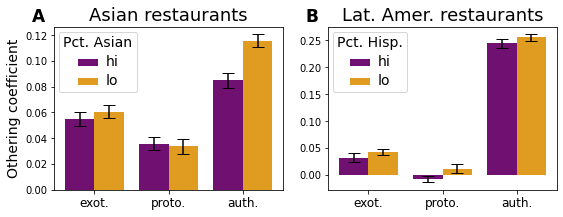

In [14]:
# Study 1: race effect

othering_df = pd.read_csv('results/asian_othering_median.csv')#,index_col=0)
hisp_othering_df = pd.read_csv('results/hisp_othering_median.csv')#,index_col=0)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9,3),sharey=False)
palette ={"hi": "purple", "lo": "orange"}
sns.barplot(data=othering_df, y='Othering score', x='frame', hue='Pct. Asian', ax=ax1, 
            hue_order=['hi','lo'], order=['exoticism','typicality','authenticity'],
            palette=palette)
x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax1.patches]
y_coords = [p.get_height() for p in ax1.patches]
ax1.errorbar(x=x_coords, y=y_coords, yerr=2*othering_df["Othering err"], fmt="none", c="k", capsize=6)
sns.barplot(data=hisp_othering_df, y='Othering score', x='frame', hue='Pct. Hisp.', ax=ax2,
            hue_order=['hi','lo'], order=['exoticism','typicality','authenticity'],
            palette=palette)
x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax2.patches]
y_coords = [p.get_height() for p in ax2.patches]
ax2.errorbar(x=x_coords, y=y_coords, yerr=2*hisp_othering_df["Othering err"], fmt="none", c="k", capsize=6)
ax1.set_ylabel("Othering coefficient", fontsize=14)
ax2.set_ylabel("")
ax2.set_title("Lat. Amer. restaurants", fontsize=18)
ax1.set_title("Asian restaurants", fontsize=18)
ax1.set_xticklabels(['exot.','proto.','auth.'], fontsize=16)
ax2.set_xticklabels(['exot.','proto.','auth.'], fontsize=16)

for ax_ix,ax in enumerate([ax1, ax2]):
    ax.set_xlabel("")
    ax.text(-0.1, 1.03, string.ascii_uppercase[ax_ix], transform=ax.transAxes, 
                size=17, weight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_legend().get_texts(), fontsize='14') 
    plt.setp(ax.get_legend().get_title(), fontsize='14') 
    
#     # Save just the portion _inside_ the second axis's boundaries
#     extent = full_extent(ax).transformed(fig.dpi_scale_trans.inverted())
#     # Alternatively,
#     # extent = ax.get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
#     print("Saving subplot to:", os.path.join(FIGURES_DIR, f"race_othering_subplot{ax_ix}.pdf"))
#     fig.savefig(os.path.join(FIGURES_DIR, f"race_othering_subplot{ax_ix}.pdf"), bbox_inches=extent)
plt.savefig(os.path.join(FIGURES_DIR,"race_othering.pdf"),bbox_inches="tight")
plt.show()

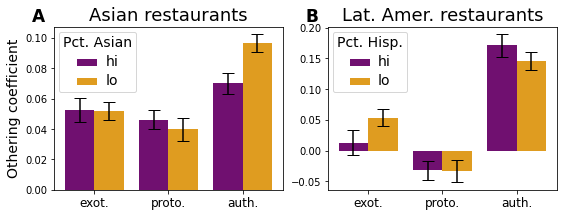

In [15]:
# Study 1: race effect; top cuisine removed

othering_df = pd.read_csv('results/top_removed_asian_othering_median.csv')#,index_col=0)
hisp_othering_df = pd.read_csv('results/top_removed_hisp_othering_median.csv')#,index_col=0)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9,3),sharey=False)
palette ={"hi": "purple", "lo": "orange"}
sns.barplot(data=othering_df, y='Othering score', x='frame', hue='Pct. Asian', ax=ax1, 
            hue_order=['hi','lo'], order=['exoticism','typicality','authenticity'],
            palette=palette)
x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax1.patches]
y_coords = [p.get_height() for p in ax1.patches]
ax1.errorbar(x=x_coords, y=y_coords, yerr=2*othering_df["Othering err"], fmt="none", c="k", capsize=6)
sns.barplot(data=hisp_othering_df, y='Othering score', x='frame', hue='Pct. Hisp.', ax=ax2,
            hue_order=['hi','lo'], order=['exoticism','typicality','authenticity'],
            palette=palette)
x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax2.patches]
y_coords = [p.get_height() for p in ax2.patches]
ax2.errorbar(x=x_coords, y=y_coords, yerr=2*hisp_othering_df["Othering err"], fmt="none", c="k", capsize=6)
ax1.set_ylabel("Othering coefficient", fontsize=14)
ax2.set_ylabel("")
ax2.set_title("Lat. Amer. restaurants", fontsize=18)
ax1.set_title("Asian restaurants", fontsize=18)
ax1.set_xticklabels(['exot.','proto.','auth.'], fontsize=16)
ax2.set_xticklabels(['exot.','proto.','auth.'], fontsize=16)

for ax_ix,ax in enumerate([ax1, ax2]):
    ax.set_xlabel("")
    ax.text(-0.1, 1.03, string.ascii_uppercase[ax_ix], transform=ax.transAxes, 
                size=17, weight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_legend().get_texts(), fontsize='14') 
    plt.setp(ax.get_legend().get_title(), fontsize='14') 
    
#     # Save just the portion _inside_ the second axis's boundaries
#     extent = full_extent(ax).transformed(fig.dpi_scale_trans.inverted())
#     # Alternatively,
#     # extent = ax.get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
#     print("Saving subplot to:", os.path.join(FIGURES_DIR, f"race_othering_subplot{ax_ix}.pdf"))
#     fig.savefig(os.path.join(FIGURES_DIR, f"race_othering_subplot{ax_ix}.pdf"), bbox_inches=extent)
plt.savefig(os.path.join(FIGURES_DIR,"top_removed_race_othering.pdf"),bbox_inches="tight")
plt.show()

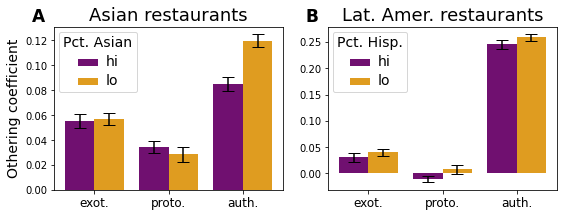

In [16]:
# Study 1: race effect; cajun/creole cuisine removed

othering_df = pd.read_csv('results/cajun-creole_removed_asian_othering_median.csv')#,index_col=0)
hisp_othering_df = pd.read_csv('results/cajun-creole_removed_hisp_othering_median.csv')#,index_col=0)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9,3),sharey=False)
palette ={"hi": "purple", "lo": "orange"}
sns.barplot(data=othering_df, y='Othering score', x='frame', hue='Pct. Asian', ax=ax1, 
            hue_order=['hi','lo'], order=['exoticism','typicality','authenticity'],
            palette=palette)
x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax1.patches]
y_coords = [p.get_height() for p in ax1.patches]
ax1.errorbar(x=x_coords, y=y_coords, yerr=2*othering_df["Othering err"], fmt="none", c="k", capsize=6)
sns.barplot(data=hisp_othering_df, y='Othering score', x='frame', hue='Pct. Hisp.', ax=ax2,
            hue_order=['hi','lo'], order=['exoticism','typicality','authenticity'],
            palette=palette)
x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax2.patches]
y_coords = [p.get_height() for p in ax2.patches]
ax2.errorbar(x=x_coords, y=y_coords, yerr=2*hisp_othering_df["Othering err"], fmt="none", c="k", capsize=6)
ax1.set_ylabel("Othering coefficient", fontsize=14)
ax2.set_ylabel("")
ax2.set_title("Lat. Amer. restaurants", fontsize=18)
ax1.set_title("Asian restaurants", fontsize=18)
ax1.set_xticklabels(['exot.','proto.','auth.'], fontsize=16)
ax2.set_xticklabels(['exot.','proto.','auth.'], fontsize=16)

for ax_ix,ax in enumerate([ax1, ax2]):
    ax.set_xlabel("")
    ax.text(-0.1, 1.03, string.ascii_uppercase[ax_ix], transform=ax.transAxes, 
                size=17, weight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_legend().get_texts(), fontsize='14') 
    plt.setp(ax.get_legend().get_title(), fontsize='14') 
    
#     # Save just the portion _inside_ the second axis's boundaries
#     extent = full_extent(ax).transformed(fig.dpi_scale_trans.inverted())
#     # Alternatively,
#     # extent = ax.get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
#     print("Saving subplot to:", os.path.join(FIGURES_DIR, f"race_othering_subplot{ax_ix}.pdf"))
#     fig.savefig(os.path.join(FIGURES_DIR, f"race_othering_subplot{ax_ix}.pdf"), bbox_inches=extent)
plt.savefig(os.path.join(FIGURES_DIR,"cajun-creole_removed_race_othering.pdf"),bbox_inches="tight")
plt.show()

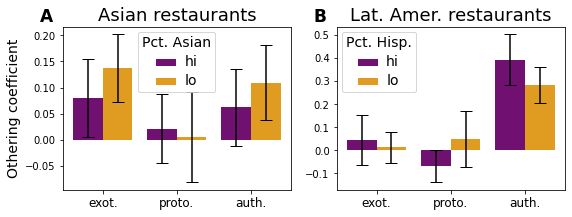

In [17]:
# Study 1: race effect; user-controlled

othering_df = pd.read_csv('results/user_cont_asian_othering_median.csv')#,index_col=0)
hisp_othering_df = pd.read_csv('results/user_cont_hisp_othering_median.csv')#,index_col=0)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9,3),sharey=False)
palette ={"hi": "purple", "lo": "orange"}
sns.barplot(data=othering_df, y='Othering score', x='frame', hue='Pct. Asian', ax=ax1, 
            hue_order=['hi','lo'], order=['exoticism','typicality','authenticity'],
            palette=palette)
x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax1.patches]
y_coords = [p.get_height() for p in ax1.patches]
ax1.errorbar(x=x_coords, y=y_coords, yerr=2*othering_df["Othering err"], fmt="none", c="k", capsize=6)
sns.barplot(data=hisp_othering_df, y='Othering score', x='frame', hue='Pct. Hisp.', ax=ax2,
            hue_order=['hi','lo'], order=['exoticism','typicality','authenticity'],
            palette=palette)
x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax2.patches]
y_coords = [p.get_height() for p in ax2.patches]
ax2.errorbar(x=x_coords, y=y_coords, yerr=2*hisp_othering_df["Othering err"], fmt="none", c="k", capsize=6)
ax1.set_ylabel("Othering coefficient", fontsize=14)
ax2.set_ylabel("")
ax2.set_title("Lat. Amer. restaurants", fontsize=18)
ax1.set_title("Asian restaurants", fontsize=18)
ax1.set_xticklabels(['exot.','proto.','auth.'], fontsize=16)
ax2.set_xticklabels(['exot.','proto.','auth.'], fontsize=16)

for ax_ix,ax in enumerate([ax1, ax2]):
    ax.set_xlabel("")
    ax.text(-0.1, 1.03, string.ascii_uppercase[ax_ix], transform=ax.transAxes, 
                size=17, weight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_legend().get_texts(), fontsize='14') 
    plt.setp(ax.get_legend().get_title(), fontsize='14') 
    
#     # Save just the portion _inside_ the second axis's boundaries
#     extent = full_extent(ax).transformed(fig.dpi_scale_trans.inverted())
#     # Alternatively,
#     # extent = ax.get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
#     print("Saving subplot to:", os.path.join(FIGURES_DIR, f"race_othering_subplot{ax_ix}.pdf"))
#     fig.savefig(os.path.join(FIGURES_DIR, f"race_othering_subplot{ax_ix}.pdf"), bbox_inches=extent)
plt.savefig(os.path.join(FIGURES_DIR,"user_cont_race_othering.pdf"),bbox_inches="tight")
plt.show()

# Study 2

Will save figure to: figs/study2_main_results.pdf


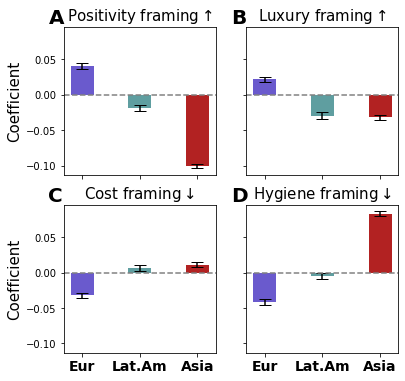

In [18]:
# Study 2 main results

fig_name = 'study2_main_results' # set name without file extension
assert type(fig_name) == str
print("Will save figure to:", os.path.join(FIGURES_DIR, f"{fig_name}.pdf"))

dep_vars_to_plot = ['filtered_liwc_posemo_agg_score',
                    'luxury_words_agg_score',
                    'cheapness_words_agg_score',
                    'hygiene_words_agg_score']

fig, axs = plt.subplots(2,2,figsize=(6,6),sharey=True,sharex=True)

region_coeff_ticks = ['europe','latin_america','asia']
pretty_region_coeff_ticks = ['Eur','Lat.Am','Asia']

for ax_ix,dep_var in enumerate(dep_vars_to_plot):

    # get results from .csvs
    res = fetch_results(dep_var, 'biz_cuisine_region')
    covar_res = fetch_results(dep_var, 'biz_cuisine_region', covars=True)
    per_region_coeffs = get_abs_coeffs(res, ref='europe', per_cuisine=False)
    per_region_errs = get_abs_errs(res, covar_res, ref='europe', per_cuisine=False)

    # Overall parameters
    ax = axs[int(ax_ix/2)][ax_ix%2]
    ax.axhline(y=0, color="gray", linestyle="--")
    ax.set_xticks(range(len(region_coeff_ticks)))
    ax.set_xticklabels(pretty_region_coeff_ticks, fontweight='bold', fontsize=14)

    # Plot coefficients
    ax.bar(range(len(region_coeff_ticks)),
           [per_region_coeffs[x] for x in region_coeff_ticks],
           width=0.4,
           yerr=[2*per_region_errs[x] for x in region_coeff_ticks],
           capsize=6,
           color=[cont2color[x] for x in region_coeff_ticks], 
           zorder=1)
        
    # Add titles 
    if ax_ix < 2:
        ax.set_title(f"{prettify_dep_var(dep_var)} framing"+r'$\uparrow$',fontsize=15)
    else:
        ax.set_title(f"{prettify_dep_var(dep_var)} framing"+r'$\downarrow$',fontsize=15)
    ax.text(-0.1, 1.02, string.ascii_uppercase[ax_ix], transform=ax.transAxes, 
            size=20, weight='bold')
    
    if ax_ix % 2 == 0:
        ax.set_ylabel("Coefficient", fontsize=15)
        
#     # Save just the portion _inside_ the second axis's boundaries
#     extent = full_extent(ax).transformed(fig.dpi_scale_trans.inverted())
#     # Alternatively,
#     # extent = ax.get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
#     print("Saving subplot to:", os.path.join(FIGURES_DIR, f"{fig_name}_subplot{ax_ix}.pdf"))
#     fig.savefig(os.path.join(FIGURES_DIR, f"{fig_name}_subplot{ax_ix}.pdf"), bbox_inches=extent)
    
plt.savefig(os.path.join(FIGURES_DIR, f"{fig_name}.pdf"),bbox_inches="tight")
plt.show()

Will save figure to: figs/study2_per_cuisine_results.pdf


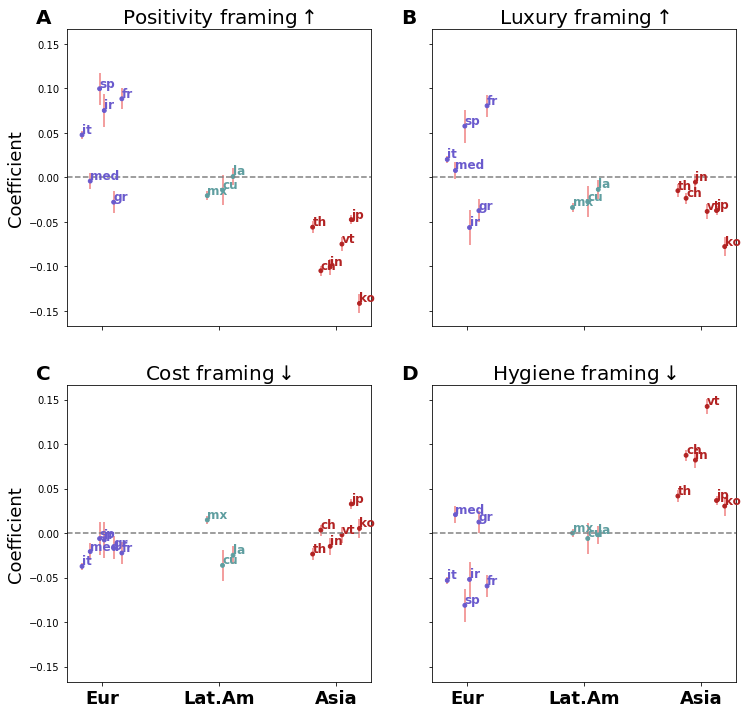

In [19]:
# Study 2 per cuisine results

jitter = {
    'us.new': -0.1,
    'so': .1,
    'us.old':-0.07,
    'caj':.07,
    'sf':-0.05,
    'fr':.17,
    'it':-.17,
    'med':-.1,
    'gr':.1,
    'ir':.02,
    'sp':-.02,
    'la':.12,
    'mx':-.1,
    'cu':.03,
    'ch':-0.13,
    'jp':.13,
    'in':-.05,
    'vt':.05,
    'th':-.2,
    'ko':.2}

fig_name = 'study2_per_cuisine_results' # set name without file extension
assert type(fig_name) == str
print("Will save figure to:", os.path.join(FIGURES_DIR, f"{fig_name}.pdf"))

dep_vars_to_plot = ['filtered_liwc_posemo_agg_score',
                    'luxury_words_agg_score',
                    'cheapness_words_agg_score',
                    'hygiene_words_agg_score']

fig, axs = plt.subplots(2,2,figsize=(12,12),sharey=True,sharex=True)

macro_coeff_ticks = ['us','non-us']
pretty_macro_coeff_ticks = ['US','non-US']
region_coeff_ticks = ['europe','latin_america','asia']
pretty_region_coeff_ticks = ['Eur','Lat.Am','Asia']
cuisine_coeff_ticks = ['french','greek','irish','italian','mediterranean','spanish',
                      'cuban','latin american','mexican',
                      'chinese','indian','japanese','korean','thai','vietnamese']
pretty_cuisine_coeff_ticks = [country2abbrev[x] for x in cuisine_coeff_ticks]

for ax_ix,dep_var in enumerate(dep_vars_to_plot):

    # get results from .csvs
    res = fetch_results(dep_var, 'biz_cuisine')
    covar_res = fetch_results(dep_var, 'biz_cuisine', covars=True)
    per_region_coeffs = get_abs_coeffs(res, per_cuisine=True)
    per_region_errs = get_abs_errs(res, covar_res, per_cuisine=True)

    # Overall parameters
    ax = axs[int(ax_ix/2)][ax_ix%2]
    ax.axhline(y=0, color="gray", linestyle="--")
    ax.set_xticks(range(len(region_coeff_ticks)))
    ax.set_xticklabels(pretty_region_coeff_ticks,fontweight='bold',fontsize=18)
    ax.set_xlim(-0.3,2.3)

    # Plot coefficients
    ax.scatter([region_coeff_ticks.index(ethnic_cat2continent[x])+jitter[country2abbrev[x]] for x in cuisine_coeff_ticks],
               [per_region_coeffs[x] for x in cuisine_coeff_ticks], 
               color=[cont2color[ethnic_cat2continent[x]] for x in cuisine_coeff_ticks], 
               zorder=2,s=15)

    # Plot errors
    for idx, coeff in enumerate(cuisine_coeff_ticks):
        offset = jitter[country2abbrev[coeff]]#len(pretty_cuisine_coeff_ticks[idx])*.083
        color = "lightcoral" #if pvals[coeff] < 0.05 else 'lightgray'
        ax.vlines(region_coeff_ticks.index(ethnic_cat2continent[coeff])+offset, 
                  per_region_coeffs[coeff]-2*per_region_errs[coeff], 
                  per_region_coeffs[coeff]+2*per_region_errs[coeff], 
                  color=color, 
                  zorder=1, linewidth=1.5)

    # Add labels
    for idx, coeff in enumerate(cuisine_coeff_ticks):
        offset = jitter[country2abbrev[coeff]]#len(pretty_cuisine_coeff_ticks[idx])*.083
        ax.annotate(pretty_cuisine_coeff_ticks[idx], 
                    (region_coeff_ticks.index(ethnic_cat2continent[coeff])+offset, per_region_coeffs[coeff]+0.002), 
                    color=cont2color[ethnic_cat2continent[coeff]],
                    fontsize=12, weight="bold")

    # Add titles 
    if ax_ix < 2:
        ax.set_title(f"{prettify_dep_var(dep_var)} framing"+r'$\uparrow$',fontsize=20)
    else:
        ax.set_title(f"{prettify_dep_var(dep_var)} framing"+r'$\downarrow$',fontsize=20)
    ax.text(-0.1, 1.02, string.ascii_uppercase[ax_ix], transform=ax.transAxes, 
            size=20, weight='bold')
    
    if ax_ix % 2 == 0:
        ax.set_ylabel("Coefficient", fontsize=18)

#     # Save just the portion _inside_ the second axis's boundaries
#     extent = full_extent(ax).transformed(fig.dpi_scale_trans.inverted())
#     # Alternatively,
#     # extent = ax.get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
#     print("Saving subplot to:", os.path.join(FIGURES_DIR, f"{fig_name}_subplot{ax_ix}.pdf"))
#     fig.savefig(os.path.join(FIGURES_DIR, f"{fig_name}_subplot{ax_ix}.pdf"), bbox_inches=extent)
    
plt.savefig(os.path.join(FIGURES_DIR, f"{fig_name}.pdf"),bbox_inches="tight")
plt.show()

Will save figure to: figs/top_removed_study2_main_results.pdf


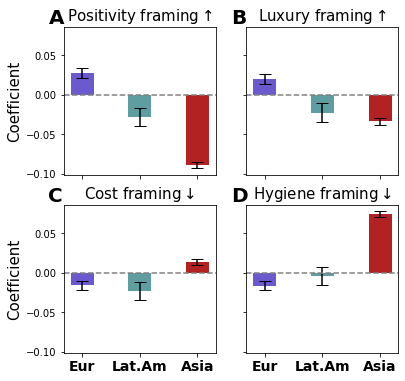

In [20]:
# Study 2 main results, top cuisine removed

fig_name = 'top_removed_study2_main_results' # set name without file extension
assert type(fig_name) == str
print("Will save figure to:", os.path.join(FIGURES_DIR, f"{fig_name}.pdf"))

dep_vars_to_plot = ['filtered_liwc_posemo_agg_score',
                    'luxury_words_agg_score',
                    'cheapness_words_agg_score',
                    'hygiene_words_agg_score']

fig, axs = plt.subplots(2,2,figsize=(6,6),sharey=True,sharex=True)

region_coeff_ticks = ['europe','latin_america','asia']
pretty_region_coeff_ticks = ['Eur','Lat.Am','Asia']

for ax_ix,dep_var in enumerate(dep_vars_to_plot):

    # get results from .csvs
    res = fetch_results(dep_var, 'biz_cuisine_region', top_removed=True)
    covar_res = fetch_results(dep_var, 'biz_cuisine_region', covars=True, top_removed=True)
    per_region_coeffs = get_abs_coeffs(res, ref='europe', per_cuisine=False)
    per_region_errs = get_abs_errs(res, covar_res, ref='europe', per_cuisine=False)

    # Overall parameters
    ax = axs[int(ax_ix/2)][ax_ix%2]
    ax.axhline(y=0, color="gray", linestyle="--")
    ax.set_xticks(range(len(region_coeff_ticks)))
    ax.set_xticklabels(pretty_region_coeff_ticks, fontweight='bold', fontsize=14)

    # Plot coefficients
    ax.bar(range(len(region_coeff_ticks)),
           [per_region_coeffs[x] for x in region_coeff_ticks],
           width=0.4,
           yerr=[2*per_region_errs[x] for x in region_coeff_ticks],
           capsize=6,
           color=[cont2color[x] for x in region_coeff_ticks], 
           zorder=1)
        
    # Add titles 
    if ax_ix < 2:
        ax.set_title(f"{prettify_dep_var(dep_var)} framing"+r'$\uparrow$',fontsize=15)
    else:
        ax.set_title(f"{prettify_dep_var(dep_var)} framing"+r'$\downarrow$',fontsize=15)
    ax.text(-0.1, 1.02, string.ascii_uppercase[ax_ix], transform=ax.transAxes, 
            size=20, weight='bold')
    
    if ax_ix % 2 == 0:
        ax.set_ylabel("Coefficient", fontsize=15)
        
#     # Save just the portion _inside_ the second axis's boundaries
#     extent = full_extent(ax).transformed(fig.dpi_scale_trans.inverted())
#     # Alternatively,
#     # extent = ax.get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
#     print("Saving subplot to:", os.path.join(FIGURES_DIR, f"{fig_name}_subplot{ax_ix}.pdf"))
#     fig.savefig(os.path.join(FIGURES_DIR, f"{fig_name}_subplot{ax_ix}.pdf"), bbox_inches=extent)
    
plt.savefig(os.path.join(FIGURES_DIR, f"{fig_name}.pdf"),bbox_inches="tight")
plt.show()

Will save figure to: figs/user_cont_study2_main_results.pdf


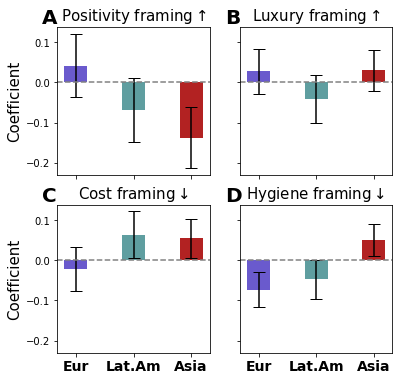

In [21]:
# Study 2 main results, user-controlled

fig_name = 'user_cont_study2_main_results' # set name without file extension
assert type(fig_name) == str
print("Will save figure to:", os.path.join(FIGURES_DIR, f"{fig_name}.pdf"))

dep_vars_to_plot = ['filtered_liwc_posemo_agg_score',
                    'luxury_words_agg_score',
                    'cheapness_words_agg_score',
                    'hygiene_words_agg_score']

fig, axs = plt.subplots(2,2,figsize=(6,6),sharey=True,sharex=True)

region_coeff_ticks = ['europe','latin_america','asia']
pretty_region_coeff_ticks = ['Eur','Lat.Am','Asia']

for ax_ix,dep_var in enumerate(dep_vars_to_plot):

    # get results from .csvs
    res = fetch_results(dep_var, 'biz_cuisine_region', user_controlled=True)
    covar_res = fetch_results(dep_var, 'biz_cuisine_region', covars=True, user_controlled=True)
    per_region_coeffs = get_abs_coeffs(res, ref='europe', per_cuisine=False)
    per_region_errs = get_abs_errs(res, covar_res, ref='europe', per_cuisine=False)

    # Overall parameters
    ax = axs[int(ax_ix/2)][ax_ix%2]
    ax.axhline(y=0, color="gray", linestyle="--")
    ax.set_xticks(range(len(region_coeff_ticks)))
    ax.set_xticklabels(pretty_region_coeff_ticks, fontweight='bold', fontsize=14)

    # Plot coefficients
    ax.bar(range(len(region_coeff_ticks)),
           [per_region_coeffs[x] for x in region_coeff_ticks],
           width=0.4,
           yerr=[2*per_region_errs[x] for x in region_coeff_ticks],
           capsize=6,
           color=[cont2color[x] for x in region_coeff_ticks], 
           zorder=1)
        
    # Add titles 
    if ax_ix < 2:
        ax.set_title(f"{prettify_dep_var(dep_var)} framing"+r'$\uparrow$',fontsize=15)
    else:
        ax.set_title(f"{prettify_dep_var(dep_var)} framing"+r'$\downarrow$',fontsize=15)
    ax.text(-0.1, 1.02, string.ascii_uppercase[ax_ix], transform=ax.transAxes, 
            size=20, weight='bold')
    
    if ax_ix % 2 == 0:
        ax.set_ylabel("Coefficient", fontsize=15)
        
#     # Save just the portion _inside_ the second axis's boundaries
#     extent = full_extent(ax).transformed(fig.dpi_scale_trans.inverted())
#     # Alternatively,
#     # extent = ax.get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
#     print("Saving subplot to:", os.path.join(FIGURES_DIR, f"{fig_name}_subplot{ax_ix}.pdf"))
#     fig.savefig(os.path.join(FIGURES_DIR, f"{fig_name}_subplot{ax_ix}.pdf"), bbox_inches=extent)
    
plt.savefig(os.path.join(FIGURES_DIR, f"{fig_name}.pdf"),bbox_inches="tight")
plt.show()

Will save figure to: figs/study2_hygiene_results.pdf


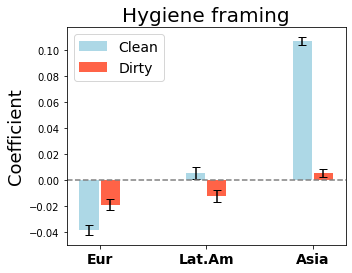

In [22]:
# Study 2 hygiene results

fig_name = 'study2_hygiene_results' # set name without file extension
assert type(fig_name) == str
print("Will save figure to:", os.path.join(FIGURES_DIR, f"{fig_name}.pdf"))

dep_vars_to_plot = ['hygiene_pos_words_agg_score',
                    'hygiene_neg_words_agg_score']

fig, ax = plt.subplots(figsize=(5,4),sharey=True,sharex=True)
# Overall parameters
ax.axhline(y=0, color="gray", linestyle="--")
ax.set_xticks(range(len(region_coeff_ticks)))
ax.set_xticklabels(pretty_region_coeff_ticks, fontweight='bold', fontsize=14)

region_coeff_ticks = ['europe','latin_america','asia']
pretty_region_coeff_ticks = ['Eur','Lat.Am','Asia']

for var_ix, dep_var in enumerate(dep_vars_to_plot):

    # get results from .csvs
    res = fetch_results(dep_var, 'biz_cuisine_region')
    covar_res = fetch_results(dep_var, 'biz_cuisine_region', covars=True)
    per_region_coeffs = get_abs_coeffs(res, ref='europe', per_cuisine=False)
    per_region_errs = get_abs_errs(res, covar_res, ref='europe', per_cuisine=False)

    # Plot aggregate coefficients
    if var_ix == 0:
        ax.bar([x-.1 for x in range(len(region_coeff_ticks))],
               [per_region_coeffs[x] for x in region_coeff_ticks],
               width=0.18,
               yerr=[2*per_region_errs[x] for x in region_coeff_ticks],
               capsize=4,
               color='lightblue',#[cont2color[x] for x in region_coeff_ticks], 
               zorder=1, label='Clean')
    if var_ix == 1:
        ax.bar([x+.1 for x in range(len(region_coeff_ticks))],
               [per_region_coeffs[x] for x in region_coeff_ticks],
               width=0.18,
               yerr=[2*per_region_errs[x] for x in region_coeff_ticks],
               capsize=4,
               color='tomato',#[cont2color[x] for x in region_coeff_ticks], 
               zorder=1, label='Dirty')
        
# Add titles 
ax.set_title("Hygiene framing",fontsize=20)
ax.set_ylabel("Coefficient", fontsize=18)
plt.legend(fontsize=14)
    
plt.savefig(os.path.join(FIGURES_DIR, f"{fig_name}.pdf"),bbox_inches="tight")
plt.show()

Will save figure to: figs/study2_per_cuisine_hygiene_results.pdf


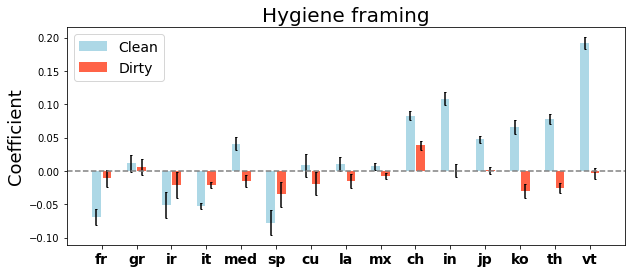

In [23]:
# study 2 per cuisine hygiene results

fig_name = 'study2_per_cuisine_hygiene_results' # set name without file extension
assert type(fig_name) == str
print("Will save figure to:", os.path.join(FIGURES_DIR, f"{fig_name}.pdf"))

dep_vars_to_plot = ['hygiene_pos_words_agg_score',
                    'hygiene_neg_words_agg_score']

fig, ax = plt.subplots(figsize=(10,4),sharey=True,sharex=True)
# Overall parameters
ax.axhline(y=0, color="gray", linestyle="--")
ax.set_xticks(range(len(cuisine_coeff_ticks)))
ax.set_xticklabels(pretty_cuisine_coeff_ticks, fontweight='bold', fontsize=14)

region_coeff_ticks = ['europe','latin_america','asia']
pretty_region_coeff_ticks = ['Eur','Lat.Am','Asia']

for var_ix, dep_var in enumerate(dep_vars_to_plot):

    # get results from .csvs
    res = fetch_results(dep_var, 'biz_cuisine')
    covar_res = fetch_results(dep_var, 'biz_cuisine', covars=True)
    per_region_coeffs = get_abs_coeffs(res, ref='europe', per_cuisine=True)
    per_region_errs = get_abs_errs(res, covar_res, ref='europe', per_cuisine=True)

    # Plot aggregate coefficients
    if var_ix == 0:
        ax.bar([x-.15 for x in range(len(cuisine_coeff_ticks))],
               [per_region_coeffs[x] for x in cuisine_coeff_ticks],
               width=0.25,
               yerr=[2*per_region_errs[x] for x in cuisine_coeff_ticks],
               capsize=1,
               color='lightblue',#[cont2color[x] for x in region_coeff_ticks], 
               zorder=1, label='Clean')
    if var_ix == 1:
        ax.bar([x+.15 for x in range(len(cuisine_coeff_ticks))],
               [per_region_coeffs[x] for x in cuisine_coeff_ticks],
               width=0.25,
               yerr=[2*per_region_errs[x] for x in cuisine_coeff_ticks],
               capsize=1,
               color='tomato',#[cont2color[x] for x in region_coeff_ticks], 
               zorder=1, label='Dirty')
        
# Add titles 
ax.set_title("Hygiene framing",fontsize=20)
ax.set_ylabel("Coefficient", fontsize=18)
plt.legend(fontsize=14)
    
plt.savefig(os.path.join(FIGURES_DIR, f"{fig_name}.pdf"),bbox_inches="tight")
plt.show()

Will save figure to: figs/top_removed_study2_hygiene_results.pdf


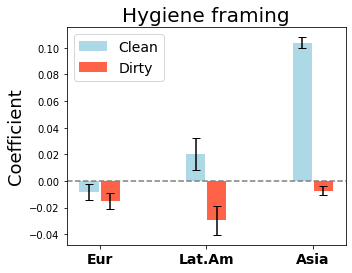

In [24]:
# Study 2 hygiene top removed

fig_name = 'top_removed_study2_hygiene_results' # set name without file extension
assert type(fig_name) == str
print("Will save figure to:", os.path.join(FIGURES_DIR, f"{fig_name}.pdf"))

dep_vars_to_plot = ['hygiene_pos_words_agg_score',
                    'hygiene_neg_words_agg_score']

fig, ax = plt.subplots(figsize=(5,4),sharey=True,sharex=True)
# Overall parameters
ax.axhline(y=0, color="gray", linestyle="--")
ax.set_xticks(range(len(region_coeff_ticks)))
ax.set_xticklabels(pretty_region_coeff_ticks, fontweight='bold', fontsize=14)

region_coeff_ticks = ['europe','latin_america','asia']
pretty_region_coeff_ticks = ['Eur','Lat.Am','Asia']

for var_ix, dep_var in enumerate(dep_vars_to_plot):

    # get results from .csvs
    res = fetch_results(dep_var, 'biz_cuisine_region', top_removed=True)
    covar_res = fetch_results(dep_var, 'biz_cuisine_region', covars=True, top_removed=True)
    per_region_coeffs = get_abs_coeffs(res, ref='europe', per_cuisine=False)
    per_region_errs = get_abs_errs(res, covar_res, ref='europe', per_cuisine=False)

    # Plot aggregate coefficients
    if var_ix == 0:
        ax.bar([x-.1 for x in range(len(region_coeff_ticks))],
               [per_region_coeffs[x] for x in region_coeff_ticks],
               width=0.18,
               yerr=[2*per_region_errs[x] for x in region_coeff_ticks],
               capsize=4,
               color='lightblue',#[cont2color[x] for x in region_coeff_ticks], 
               zorder=1, label='Clean')
    if var_ix == 1:
        ax.bar([x+.1 for x in range(len(region_coeff_ticks))],
               [per_region_coeffs[x] for x in region_coeff_ticks],
               width=0.18,
               yerr=[2*per_region_errs[x] for x in region_coeff_ticks],
               capsize=4,
               color='tomato',#[cont2color[x] for x in region_coeff_ticks], 
               zorder=1, label='Dirty')
        
# Add titles 
ax.set_title("Hygiene framing",fontsize=20)
ax.set_ylabel("Coefficient", fontsize=18)
plt.legend(fontsize=14)
    
plt.savefig(os.path.join(FIGURES_DIR, f"{fig_name}.pdf"),bbox_inches="tight")
plt.show()

Will save figure to: figs/user_cont_study2_hygiene_results.pdf


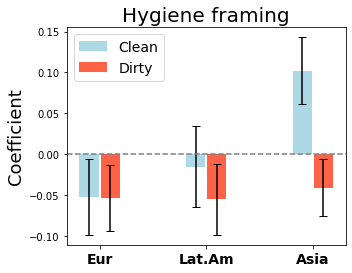

In [25]:
# Study 2 hygiene user controlled

fig_name = 'user_cont_study2_hygiene_results' # set name without file extension
assert type(fig_name) == str
print("Will save figure to:", os.path.join(FIGURES_DIR, f"{fig_name}.pdf"))

dep_vars_to_plot = ['hygiene_pos_words_agg_score',
                    'hygiene_neg_words_agg_score']

fig, ax = plt.subplots(figsize=(5,4),sharey=True,sharex=True)
# Overall parameters
ax.axhline(y=0, color="gray", linestyle="--")
ax.set_xticks(range(len(region_coeff_ticks)))
ax.set_xticklabels(pretty_region_coeff_ticks, fontweight='bold', fontsize=14)

region_coeff_ticks = ['europe','latin_america','asia']
pretty_region_coeff_ticks = ['Eur','Lat.Am','Asia']

for var_ix, dep_var in enumerate(dep_vars_to_plot):

    # get results from .csvs
    res = fetch_results(dep_var, 'biz_cuisine_region', user_controlled=True)
    covar_res = fetch_results(dep_var, 'biz_cuisine_region', covars=True, user_controlled=True)
    per_region_coeffs = get_abs_coeffs(res, ref='europe', per_cuisine=False)
    per_region_errs = get_abs_errs(res, covar_res, ref='europe', per_cuisine=False)

    # Plot aggregate coefficients
    if var_ix == 0:
        ax.bar([x-.1 for x in range(len(region_coeff_ticks))],
               [per_region_coeffs[x] for x in region_coeff_ticks],
               width=0.18,
               yerr=[2*per_region_errs[x] for x in region_coeff_ticks],
               capsize=4,
               color='lightblue',#[cont2color[x] for x in region_coeff_ticks], 
               zorder=1, label='Clean')
    if var_ix == 1:
        ax.bar([x+.1 for x in range(len(region_coeff_ticks))],
               [per_region_coeffs[x] for x in region_coeff_ticks],
               width=0.18,
               yerr=[2*per_region_errs[x] for x in region_coeff_ticks],
               capsize=4,
               color='tomato',#[cont2color[x] for x in region_coeff_ticks], 
               zorder=1, label='Dirty')
        
# Add titles 
ax.set_title("Hygiene framing",fontsize=20)
ax.set_ylabel("Coefficient", fontsize=18)
plt.legend(fontsize=14)
    
plt.savefig(os.path.join(FIGURES_DIR, f"{fig_name}.pdf"),bbox_inches="tight")
plt.show()

Will save figure to: figs/study2_cost_results.pdf


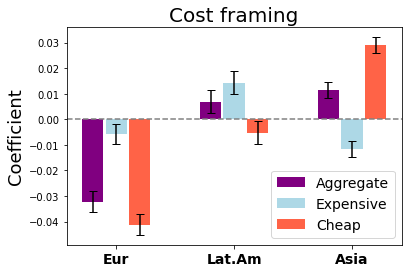

In [26]:
# Study 2 cost results

fig_name = 'study2_cost_results' # set name without file extension
assert type(fig_name) == str
print("Will save figure to:", os.path.join(FIGURES_DIR, f"{fig_name}.pdf"))

dep_vars_to_plot = ['cheapness_words_agg_score',
                    'cheapness_exp_words_agg_score',
                    'cheapness_cheap_words_agg_score']

fig, ax = plt.subplots(figsize=(6,4),sharey=True,sharex=True)
# Overall parameters
ax.axhline(y=0, color="gray", linestyle="--")
ax.set_xticks(range(len(region_coeff_ticks)))
ax.set_xticklabels(pretty_region_coeff_ticks, fontweight='bold', fontsize=14)

region_coeff_ticks = ['europe','latin_america','asia']
pretty_region_coeff_ticks = ['Eur','Lat.Am','Asia']

for var_ix, dep_var in enumerate(dep_vars_to_plot):

    # get results from .csvs
    res = fetch_results(dep_var, 'biz_cuisine_region')
    covar_res = fetch_results(dep_var, 'biz_cuisine_region', covars=True)
    per_region_coeffs = get_abs_coeffs(res, ref='europe', per_cuisine=False)
    per_region_errs = get_abs_errs(res, covar_res, ref='europe', per_cuisine=False)

    # Plot aggregate coefficients
    if var_ix == 0:
        ax.bar([x-0.2 for x in range(len(region_coeff_ticks))],
               [per_region_coeffs[x] for x in region_coeff_ticks],
               width=0.18,
               yerr=[2*per_region_errs[x] for x in region_coeff_ticks],
               capsize=4,
               color='purple',#[cont2color[x] for x in region_coeff_ticks], 
               zorder=1, label='Aggregate')
    if var_ix == 1:
        ax.bar(range(len(region_coeff_ticks)),
               [per_region_coeffs[x] for x in region_coeff_ticks],
               width=0.18,
               yerr=[2*per_region_errs[x] for x in region_coeff_ticks],
               capsize=4,
               color='lightblue',#[cont2color[x] for x in region_coeff_ticks], 
               zorder=1, label='Expensive')
    if var_ix == 2:
        ax.bar([x+.2 for x in range(len(region_coeff_ticks))],
               [per_region_coeffs[x] for x in region_coeff_ticks],
               width=0.18,
               yerr=[2*per_region_errs[x] for x in region_coeff_ticks],
               capsize=4,
               color='tomato',#[cont2color[x] for x in region_coeff_ticks], 
               zorder=1, label='Cheap')
        
# Add titles 
ax.set_title("Cost framing",fontsize=20)
ax.set_ylabel("Coefficient", fontsize=18)
plt.legend(fontsize=14)
    
plt.savefig(os.path.join(FIGURES_DIR, f"{fig_name}.pdf"),bbox_inches="tight")
plt.show()

Will save figure to: figs/study2_per_cuisine_cost_results.pdf


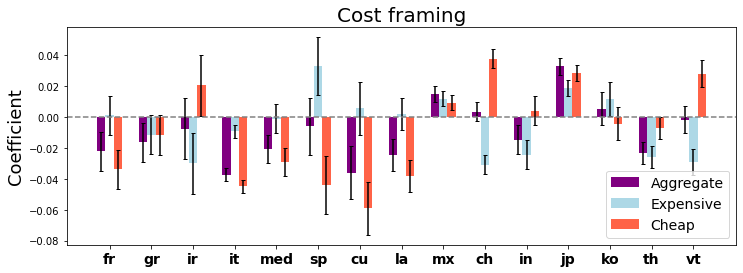

In [27]:
# Study 2 cost results, per cuisine

fig_name = 'study2_per_cuisine_cost_results' # set name without file extension
assert type(fig_name) == str
print("Will save figure to:", os.path.join(FIGURES_DIR, f"{fig_name}.pdf"))

dep_vars_to_plot = ['cheapness_words_agg_score',
                    'cheapness_exp_words_agg_score',
                    'cheapness_cheap_words_agg_score']

fig, ax = plt.subplots(figsize=(12,4),sharey=True,sharex=True)
# Overall parameters
ax.axhline(y=0, color="gray", linestyle="--")
ax.set_xticks(range(len(cuisine_coeff_ticks)))
ax.set_xticklabels(pretty_cuisine_coeff_ticks, fontweight='bold', fontsize=14)

region_coeff_ticks = ['europe','latin_america','asia']
pretty_region_coeff_ticks = ['Eur','Lat.Am','Asia']

for var_ix, dep_var in enumerate(dep_vars_to_plot):

    # get results from .csvs
    res = fetch_results(dep_var, 'biz_cuisine')
    covar_res = fetch_results(dep_var, 'biz_cuisine', covars=True)
    per_region_coeffs = get_abs_coeffs(res, per_cuisine=True)
    per_region_errs = get_abs_errs(res, covar_res, per_cuisine=True)

    # Plot aggregate coefficients
    if var_ix == 0:
        ax.bar([x-0.2 for x in range(len(cuisine_coeff_ticks))],
               [per_region_coeffs[x] for x in cuisine_coeff_ticks],
               width=0.2,
               yerr=[2*per_region_errs[x] for x in cuisine_coeff_ticks],
               capsize=2,
               color='purple',#[cont2color[x] for x in region_coeff_ticks], 
               zorder=1, label='Aggregate')
    if var_ix == 1:
        ax.bar(range(len(cuisine_coeff_ticks)),
               [per_region_coeffs[x] for x in cuisine_coeff_ticks],
               width=0.2,
               yerr=[2*per_region_errs[x] for x in cuisine_coeff_ticks],
               capsize=2,
               color='lightblue',#[cont2color[x] for x in region_coeff_ticks], 
               zorder=1, label='Expensive')
    if var_ix == 2:
        ax.bar([x+.2 for x in range(len(cuisine_coeff_ticks))],
               [per_region_coeffs[x] for x in cuisine_coeff_ticks],
               width=0.2,
               yerr=[2*per_region_errs[x] for x in cuisine_coeff_ticks],
               capsize=2,
               color='tomato',#[cont2color[x] for x in region_coeff_ticks], 
               zorder=1, label='Cheap')
        
# Add titles 
ax.set_title("Cost framing",fontsize=20)
ax.set_ylabel("Coefficient", fontsize=18)
plt.legend(fontsize=14)
    
plt.savefig(os.path.join(FIGURES_DIR, f"{fig_name}.pdf"),bbox_inches="tight")
plt.show()

Will save figure to: figs/top_removed_study2_cost_results.pdf


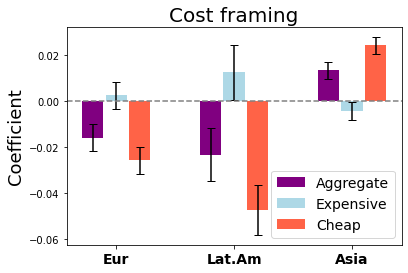

In [28]:
# Study 2 cost results top removed

fig_name = 'top_removed_study2_cost_results' # set name without file extension
assert type(fig_name) == str
print("Will save figure to:", os.path.join(FIGURES_DIR, f"{fig_name}.pdf"))

dep_vars_to_plot = ['cheapness_words_agg_score',
                    'cheapness_exp_words_agg_score',
                    'cheapness_cheap_words_agg_score']

fig, ax = plt.subplots(figsize=(6,4),sharey=True,sharex=True)
# Overall parameters
ax.axhline(y=0, color="gray", linestyle="--")
ax.set_xticks(range(len(region_coeff_ticks)))
ax.set_xticklabels(pretty_region_coeff_ticks, fontweight='bold', fontsize=14)

region_coeff_ticks = ['europe','latin_america','asia']
pretty_region_coeff_ticks = ['Eur','Lat.Am','Asia']

for var_ix, dep_var in enumerate(dep_vars_to_plot):

    # get results from .csvs
    res = fetch_results(dep_var, 'biz_cuisine_region', top_removed=True)
    covar_res = fetch_results(dep_var, 'biz_cuisine_region', covars=True, top_removed=True)
    per_region_coeffs = get_abs_coeffs(res, ref='europe', per_cuisine=False)
    per_region_errs = get_abs_errs(res, covar_res, ref='europe', per_cuisine=False)

    # Plot aggregate coefficients
    if var_ix == 0:
        ax.bar([x-0.2 for x in range(len(region_coeff_ticks))],
               [per_region_coeffs[x] for x in region_coeff_ticks],
               width=0.18,
               yerr=[2*per_region_errs[x] for x in region_coeff_ticks],
               capsize=4,
               color='purple',#[cont2color[x] for x in region_coeff_ticks], 
               zorder=1, label='Aggregate')
    if var_ix == 1:
        ax.bar(range(len(region_coeff_ticks)),
               [per_region_coeffs[x] for x in region_coeff_ticks],
               width=0.18,
               yerr=[2*per_region_errs[x] for x in region_coeff_ticks],
               capsize=4,
               color='lightblue',#[cont2color[x] for x in region_coeff_ticks], 
               zorder=1, label='Expensive')
    if var_ix == 2:
        ax.bar([x+.2 for x in range(len(region_coeff_ticks))],
               [per_region_coeffs[x] for x in region_coeff_ticks],
               width=0.18,
               yerr=[2*per_region_errs[x] for x in region_coeff_ticks],
               capsize=4,
               color='tomato',#[cont2color[x] for x in region_coeff_ticks], 
               zorder=1, label='Cheap')
        
# Add titles 
ax.set_title("Cost framing",fontsize=20)
ax.set_ylabel("Coefficient", fontsize=18)
plt.legend(fontsize=14)
    
plt.savefig(os.path.join(FIGURES_DIR, f"{fig_name}.pdf"),bbox_inches="tight")
plt.show()

Will save figure to: figs/user_cont_study2_cost_results.pdf


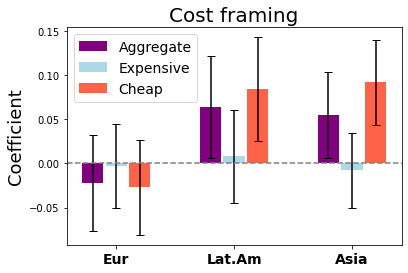

In [29]:
# Study 2 cost results user controlled

fig_name = 'user_cont_study2_cost_results' # set name without file extension
assert type(fig_name) == str
print("Will save figure to:", os.path.join(FIGURES_DIR, f"{fig_name}.pdf"))

dep_vars_to_plot = ['cheapness_words_agg_score',
                    'cheapness_exp_words_agg_score',
                    'cheapness_cheap_words_agg_score']

fig, ax = plt.subplots(figsize=(6,4),sharey=True,sharex=True)
# Overall parameters
ax.axhline(y=0, color="gray", linestyle="--")
ax.set_xticks(range(len(region_coeff_ticks)))
ax.set_xticklabels(pretty_region_coeff_ticks, fontweight='bold', fontsize=14)

region_coeff_ticks = ['europe','latin_america','asia']
pretty_region_coeff_ticks = ['Eur','Lat.Am','Asia']

for var_ix, dep_var in enumerate(dep_vars_to_plot):

    # get results from .csvs
    res = fetch_results(dep_var, 'biz_cuisine_region', user_controlled=True)
    covar_res = fetch_results(dep_var, 'biz_cuisine_region', covars=True, user_controlled=True)
    per_region_coeffs = get_abs_coeffs(res, ref='europe', per_cuisine=False)
    per_region_errs = get_abs_errs(res, covar_res, ref='europe', per_cuisine=False)

    # Plot aggregate coefficients
    if var_ix == 0:
        ax.bar([x-0.2 for x in range(len(region_coeff_ticks))],
               [per_region_coeffs[x] for x in region_coeff_ticks],
               width=0.18,
               yerr=[2*per_region_errs[x] for x in region_coeff_ticks],
               capsize=4,
               color='purple',#[cont2color[x] for x in region_coeff_ticks], 
               zorder=1, label='Aggregate')
    if var_ix == 1:
        ax.bar(range(len(region_coeff_ticks)),
               [per_region_coeffs[x] for x in region_coeff_ticks],
               width=0.18,
               yerr=[2*per_region_errs[x] for x in region_coeff_ticks],
               capsize=4,
               color='lightblue',#[cont2color[x] for x in region_coeff_ticks], 
               zorder=1, label='Expensive')
    if var_ix == 2:
        ax.bar([x+.2 for x in range(len(region_coeff_ticks))],
               [per_region_coeffs[x] for x in region_coeff_ticks],
               width=0.18,
               yerr=[2*per_region_errs[x] for x in region_coeff_ticks],
               capsize=4,
               color='tomato',#[cont2color[x] for x in region_coeff_ticks], 
               zorder=1, label='Cheap')
        
# Add titles 
ax.set_title("Cost framing",fontsize=20)
ax.set_ylabel("Coefficient", fontsize=18)
plt.legend(fontsize=14)
    
plt.savefig(os.path.join(FIGURES_DIR, f"{fig_name}.pdf"),bbox_inches="tight")
plt.show()

Will save figure to: figs/glass_ceiling_results.pdf


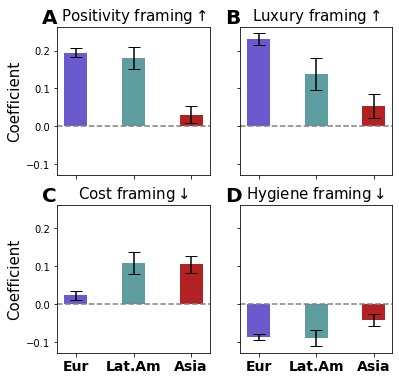

In [30]:
# Study 2 glass ceiling results

fig_name = 'glass_ceiling_results' # set name without file extension
assert type(fig_name) == str
print("Will save figure to:", os.path.join(FIGURES_DIR, f"{fig_name}.pdf"))

dep_vars_to_plot = ['filtered_liwc_posemo_agg_score',
                    'luxury_words_agg_score',
                    'cheapness_words_agg_score',
                    'hygiene_words_agg_score']

fig, axs = plt.subplots(2,2,figsize=(6,6),sharey=True,sharex=True)

region_coeff_ticks = ['europe','latin_america','asia']
pretty_region_coeff_ticks = ['Eur','Lat.Am','Asia']

for ax_ix,dep_var in enumerate(dep_vars_to_plot):

    # get results from .csvs
    res = fetch_results(dep_var, 'biz_cuisine_region', glass_ceiling=True)
    covar_res = fetch_results(dep_var, 'biz_cuisine_region', covars=True, glass_ceiling=True)
    per_region_coeffs = get_abs_coeffs(res, ref='europe', per_cuisine=False)
    per_region_errs = get_abs_errs(res, covar_res, ref='europe', per_cuisine=False)

    # Overall parameters
    ax = axs[int(ax_ix/2)][ax_ix%2]
    ax.axhline(y=0, color="gray", linestyle="--")
    ax.set_xticks(range(len(region_coeff_ticks)))
    ax.set_xticklabels(pretty_region_coeff_ticks, fontweight='bold', fontsize=14)

    # Plot coefficients
    ax.bar(range(len(region_coeff_ticks)),
           [per_region_coeffs[x] for x in region_coeff_ticks],
           width=0.4,
           yerr=[2*per_region_errs[x] for x in region_coeff_ticks],
           capsize=6,
           color=[cont2color[x] for x in region_coeff_ticks], 
           zorder=1)
        
    # Add titles 
    if ax_ix < 2:
        ax.set_title(f"{prettify_dep_var(dep_var)} framing"+r'$\uparrow$',fontsize=15)
    else:
        ax.set_title(f"{prettify_dep_var(dep_var)} framing"+r'$\downarrow$',fontsize=15)
    ax.text(-0.1, 1.02, string.ascii_uppercase[ax_ix], transform=ax.transAxes, 
            size=20, weight='bold')
    
    if ax_ix % 2 == 0:
        ax.set_ylabel("Coefficient", fontsize=15)
        
#     # Save just the portion _inside_ the second axis's boundaries
#     extent = full_extent(ax).transformed(fig.dpi_scale_trans.inverted())
#     # Alternatively,
#     # extent = ax.get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
#     print("Saving subplot to:", os.path.join(FIGURES_DIR, f"{fig_name}_subplot{ax_ix}.pdf"))
#     fig.savefig(os.path.join(FIGURES_DIR, f"{fig_name}_subplot{ax_ix}.pdf"), bbox_inches=extent)
    
plt.savefig(os.path.join(FIGURES_DIR, f"{fig_name}.pdf"),bbox_inches="tight")
plt.show()

Will save figure to: figs/glass_ceiling_per_cuisine_results.pdf


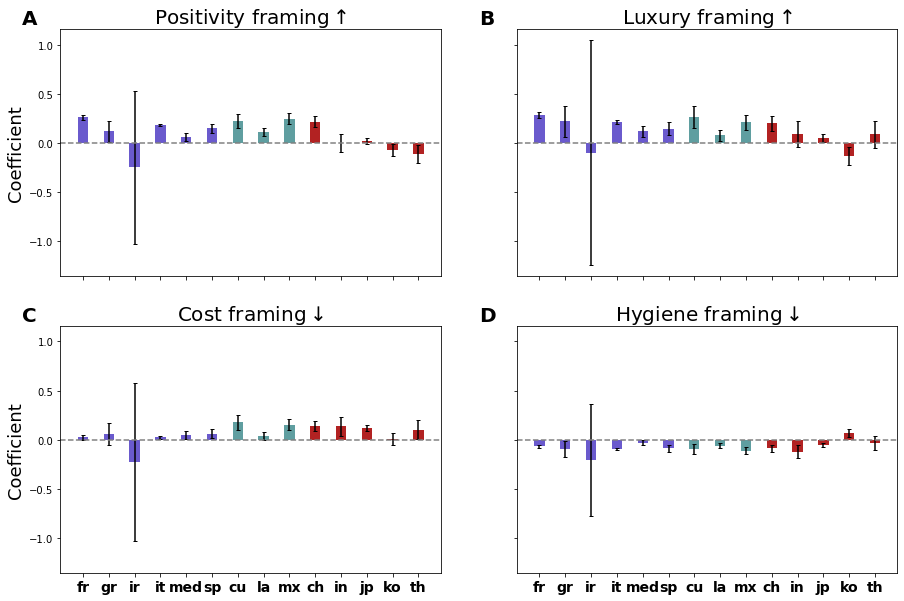

In [31]:
# Study 2 glass ceiling per cuisine results

fig_name = 'glass_ceiling_per_cuisine_results' # set name without file extension
assert type(fig_name) == str
print("Will save figure to:", os.path.join(FIGURES_DIR, f"{fig_name}.pdf"))

dep_vars_to_plot = ['filtered_liwc_posemo_agg_score',
                    'luxury_words_agg_score',
                    'cheapness_words_agg_score',
                    'hygiene_words_agg_score']

fig, axs = plt.subplots(2,2,figsize=(15,10),sharey=True,sharex=True)

region_coeff_ticks = ['europe','latin_america','asia']
pretty_region_coeff_ticks = ['Eur','Lat.Am','Asia']

for ax_ix,dep_var in enumerate(dep_vars_to_plot):

    # get results from .csvs
    res = fetch_results(dep_var, 'biz_cuisine', glass_ceiling=True)
    covar_res = fetch_results(dep_var, 'biz_cuisine', covars=True, glass_ceiling=True)
    per_region_coeffs = get_abs_coeffs(res, per_cuisine=True)
    per_region_errs = get_abs_errs(res, covar_res, per_cuisine=True)

    # Overall parameters
    ax = axs[int(ax_ix/2)][ax_ix%2]
    ax.axhline(y=0, color="gray", linestyle="--")
    ax.set_xticks(range(len([x for x in cuisine_coeff_ticks if x in per_region_coeffs])))
    ax.set_xticklabels([country2abbrev[x] for x in cuisine_coeff_ticks 
                        if x in per_region_coeffs], fontweight='bold', fontsize=14)

    # Plot coefficients
    ax.bar(range(len([x for x in cuisine_coeff_ticks if x in per_region_coeffs])),
           [per_region_coeffs[x] for x in cuisine_coeff_ticks
            if x in per_region_coeffs],
           width=0.4,
           yerr=[2*per_region_errs[x] for x in cuisine_coeff_ticks
                 if x in per_region_coeffs],
           capsize=2,
           color=[cont2color[ethnic_cat2continent[x]] for x in cuisine_coeff_ticks
                  if x in per_region_coeffs], 
           zorder=1)
        
    # Add titles 
    if ax_ix < 2:
        ax.set_title(f"{prettify_dep_var(dep_var)} framing"+r'$\uparrow$',fontsize=20)
    else:
        ax.set_title(f"{prettify_dep_var(dep_var)} framing"+r'$\downarrow$',fontsize=20)
    ax.text(-0.1, 1.02, string.ascii_uppercase[ax_ix], transform=ax.transAxes, 
            size=20, weight='bold')
    
    if ax_ix % 2 == 0:
        ax.set_ylabel("Coefficient", fontsize=18)
        
#     # Save just the portion _inside_ the second axis's boundaries
#     extent = full_extent(ax).transformed(fig.dpi_scale_trans.inverted())
#     # Alternatively,
#     # extent = ax.get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
#     print("Saving subplot to:", os.path.join(FIGURES_DIR, f"{fig_name}_subplot{ax_ix}.pdf"))
#     fig.savefig(os.path.join(FIGURES_DIR, f"{fig_name}_subplot{ax_ix}.pdf"), bbox_inches=extent)
    
plt.savefig(os.path.join(FIGURES_DIR, f"{fig_name}.pdf"),bbox_inches="tight")
plt.show()

Will save figure to: figs/top_removed_glass_ceiling_per_cuisine_results.pdf


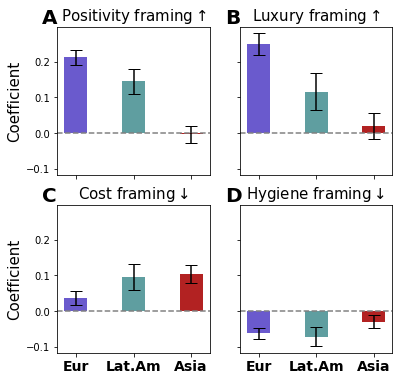

In [32]:
# Study 2 glass ceiling top cuisine removed results

fig_name = 'top_removed_glass_ceiling_per_cuisine_results' # set name without file extension
assert type(fig_name) == str
print("Will save figure to:", os.path.join(FIGURES_DIR, f"{fig_name}.pdf"))

dep_vars_to_plot = ['filtered_liwc_posemo_agg_score',
                    'luxury_words_agg_score',
                    'cheapness_words_agg_score',
                    'hygiene_words_agg_score']

fig, axs = plt.subplots(2,2,figsize=(6,6),sharey=True,sharex=True)

region_coeff_ticks = ['europe','latin_america','asia']
pretty_region_coeff_ticks = ['Eur','Lat.Am','Asia']

for ax_ix,dep_var in enumerate(dep_vars_to_plot):

    # get results from .csvs
    res = fetch_results(dep_var, 'biz_cuisine_region', glass_ceiling=True, top_removed=True)
    covar_res = fetch_results(dep_var, 'biz_cuisine_region', covars=True, glass_ceiling=True, top_removed=True)
    per_region_coeffs = get_abs_coeffs(res, ref='europe', per_cuisine=False)
    per_region_errs = get_abs_errs(res, covar_res, ref='europe', per_cuisine=False)

    # Overall parameters
    ax = axs[int(ax_ix/2)][ax_ix%2]
    ax.axhline(y=0, color="gray", linestyle="--")
    ax.set_xticks(range(len(region_coeff_ticks)))
    ax.set_xticklabels(pretty_region_coeff_ticks, fontweight='bold', fontsize=14)

    # Plot coefficients
    ax.bar(range(len(region_coeff_ticks)),
           [per_region_coeffs[x] for x in region_coeff_ticks],
           width=0.4,
           yerr=[2*per_region_errs[x] for x in region_coeff_ticks],
           capsize=6,
           color=[cont2color[x] for x in region_coeff_ticks], 
           zorder=1)
        
    # Add titles 
    if ax_ix < 2:
        ax.set_title(f"{prettify_dep_var(dep_var)} framing"+r'$\uparrow$',fontsize=15)
    else:
        ax.set_title(f"{prettify_dep_var(dep_var)} framing"+r'$\downarrow$',fontsize=15)
    ax.text(-0.1, 1.02, string.ascii_uppercase[ax_ix], transform=ax.transAxes, 
            size=20, weight='bold')
    
    if ax_ix % 2 == 0:
        ax.set_ylabel("Coefficient", fontsize=15)
        
#     # Save just the portion _inside_ the second axis's boundaries
#     extent = full_extent(ax).transformed(fig.dpi_scale_trans.inverted())
#     # Alternatively,
#     # extent = ax.get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
#     print("Saving subplot to:", os.path.join(FIGURES_DIR, f"{fig_name}_subplot{ax_ix}.pdf"))
#     fig.savefig(os.path.join(FIGURES_DIR, f"{fig_name}_subplot{ax_ix}.pdf"), bbox_inches=extent)
    
plt.savefig(os.path.join(FIGURES_DIR, f"{fig_name}.pdf"),bbox_inches="tight")
plt.show()

Will save figure to: figs/user_cont_glass_ceiling_per_cuisine_results.pdf


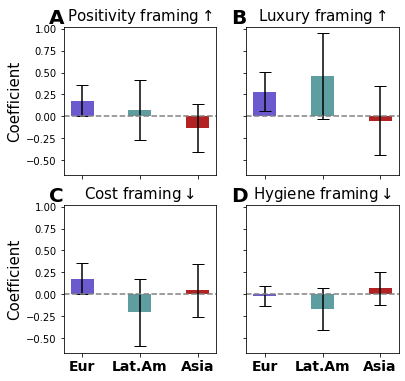

In [33]:
# Study 2 glass ceiling user controlled results

fig_name = 'user_cont_glass_ceiling_per_cuisine_results' # set name without file extension
assert type(fig_name) == str
print("Will save figure to:", os.path.join(FIGURES_DIR, f"{fig_name}.pdf"))

dep_vars_to_plot = ['filtered_liwc_posemo_agg_score',
                    'luxury_words_agg_score',
                    'cheapness_words_agg_score',
                    'hygiene_words_agg_score']

fig, axs = plt.subplots(2,2,figsize=(6,6),sharey=True,sharex=True)

region_coeff_ticks = ['europe','latin_america','asia']
pretty_region_coeff_ticks = ['Eur','Lat.Am','Asia']

for ax_ix,dep_var in enumerate(dep_vars_to_plot):

    # get results from .csvs
    res = fetch_results(dep_var, 'biz_cuisine_region', glass_ceiling=True, user_controlled=True)
    covar_res = fetch_results(dep_var, 'biz_cuisine_region', covars=True, glass_ceiling=True, user_controlled=True)
    per_region_coeffs = get_abs_coeffs(res, ref='europe', per_cuisine=False)
    per_region_errs = get_abs_errs(res, covar_res, ref='europe', per_cuisine=False)

    # Overall parameters
    ax = axs[int(ax_ix/2)][ax_ix%2]
    ax.axhline(y=0, color="gray", linestyle="--")
    ax.set_xticks(range(len(region_coeff_ticks)))
    ax.set_xticklabels(pretty_region_coeff_ticks, fontweight='bold', fontsize=14)

    # Plot coefficients
    ax.bar(range(len(region_coeff_ticks)),
           [per_region_coeffs[x] for x in region_coeff_ticks],
           width=0.4,
           yerr=[2*per_region_errs[x] for x in region_coeff_ticks],
           capsize=6,
           color=[cont2color[x] for x in region_coeff_ticks], 
           zorder=1)
        
    # Add titles 
    if ax_ix < 2:
        ax.set_title(f"{prettify_dep_var(dep_var)} framing"+r'$\uparrow$',fontsize=15)
    else:
        ax.set_title(f"{prettify_dep_var(dep_var)} framing"+r'$\downarrow$',fontsize=15)
    ax.text(-0.1, 1.02, string.ascii_uppercase[ax_ix], transform=ax.transAxes, 
            size=20, weight='bold')
    
    if ax_ix % 2 == 0:
        ax.set_ylabel("Coefficient", fontsize=15)
        
#     # Save just the portion _inside_ the second axis's boundaries
#     extent = full_extent(ax).transformed(fig.dpi_scale_trans.inverted())
#     # Alternatively,
#     # extent = ax.get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
#     print("Saving subplot to:", os.path.join(FIGURES_DIR, f"{fig_name}_subplot{ax_ix}.pdf"))
#     fig.savefig(os.path.join(FIGURES_DIR, f"{fig_name}_subplot{ax_ix}.pdf"), bbox_inches=extent)
    
plt.savefig(os.path.join(FIGURES_DIR, f"{fig_name}.pdf"),bbox_inches="tight")
plt.show()

# Study 3: LLM reviews

In [34]:
# Othering macro region results
res = fetch_results('exotic_words_agg_score', 'biz_macro_region', results_dir='llm_results')
display(res)
print(get_abs_coeffs(res))
res = fetch_results('auth_words_agg_score', 'biz_macro_region', results_dir='llm_results')
display(res)
print(get_abs_coeffs(res))
res = fetch_results('typic_words_agg_score', 'biz_macro_region', results_dir='llm_results')
display(res)
print(get_abs_coeffs(res))

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.0417,0.041,-1.014,0.311,-0.122,0.039
"C(biz_macro_region, Treatment(reference='us'))[T.non-us]",0.0487,0.026,1.840,0.066,-0.003,0.101
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Negative]",0.1035,0.050,2.074,0.038,0.006,0.201
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Positive]",-0.0092,0.044,-0.211,0.833,-0.095,0.076
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Very negative]",0.0867,0.050,1.729,0.084,-0.012,0.185
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Very positive]",-0.0276,0.042,-0.660,0.509,-0.110,0.054
review_len,0.1182,0.013,9.137,0.000,0.093,0.144


{'non-us': 0.006999999999999999, 'us': -0.0417}


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.3531,0.038,-9.302,0.000,-0.427,-0.279
"C(biz_macro_region, Treatment(reference='us'))[T.non-us]",0.3164,0.024,12.952,0.000,0.269,0.364
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Negative]",-0.0903,0.046,-1.963,0.050,-0.181,-0.000
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Positive]",0.1504,0.040,3.736,0.000,0.071,0.229
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Very negative]",-0.0973,0.046,-2.102,0.036,-0.188,-0.007
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Very positive]",0.2219,0.039,5.738,0.000,0.146,0.298
review_len,0.2871,0.012,24.048,0.000,0.264,0.311


{'non-us': -0.03670000000000001, 'us': -0.3531}


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0857,0.041,2.102,0.036,0.006,0.166
"C(biz_macro_region, Treatment(reference='us'))[T.non-us]",-0.1520,0.026,-5.794,0.000,-0.203,-0.101
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Negative]",0.1590,0.049,3.216,0.001,0.062,0.256
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Positive]",0.0372,0.043,0.861,0.389,-0.048,0.122
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Very negative]",0.0774,0.050,1.556,0.120,-0.020,0.175
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Very positive]",-0.0122,0.042,-0.294,0.768,-0.094,0.069
review_len,0.1724,0.013,13.437,0.000,0.147,0.198


{'non-us': -0.0663, 'us': 0.0857}


In [67]:
# Othering results
res = fetch_results('exotic_words_agg_score', 'biz_cuisine_region', results_dir='llm_results')
display(res)
print(get_abs_coeffs(res))
res = fetch_results('auth_words_agg_score', 'biz_cuisine_region', results_dir='llm_results')
display(res)
print(get_abs_coeffs(res))
res = fetch_results('typic_words_agg_score', 'biz_cuisine_region', results_dir='llm_results')
display(res)
print(get_abs_coeffs(res))

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.0391,0.041,-0.951,0.342,-0.120,0.042
"C(biz_cuisine_region, Treatment(reference='us'))[T.asia]",0.0666,0.032,2.051,0.040,0.003,0.130
"C(biz_cuisine_region, Treatment(reference='us'))[T.europe]",-0.0121,0.032,-0.376,0.707,-0.075,0.051
"C(biz_cuisine_region, Treatment(reference='us'))[T.latin_america]",0.0931,0.032,2.878,0.004,0.030,0.157
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Negative]",0.1024,0.050,2.054,0.040,0.005,0.200
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Positive]",-0.0127,0.044,-0.290,0.772,-0.098,0.073
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Very negative]",0.0853,0.050,1.702,0.089,-0.013,0.184
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Very positive]",-0.0318,0.042,-0.760,0.447,-0.114,0.050
review_len,0.1175,0.013,9.077,0.000,0.092,0.143


{'asia': 0.027500000000000004, 'europe': -0.0512, 'latin_america': 0.054, 'us': -0.0391}


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.3531,0.038,-9.300,0.000,-0.428,-0.279
"C(biz_cuisine_region, Treatment(reference='us'))[T.asia]",0.3033,0.030,10.123,0.000,0.245,0.362
"C(biz_cuisine_region, Treatment(reference='us'))[T.europe]",0.3155,0.030,10.590,0.000,0.257,0.374
"C(biz_cuisine_region, Treatment(reference='us'))[T.latin_america]",0.3301,0.030,11.052,0.000,0.272,0.389
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Negative]",-0.0903,0.046,-1.963,0.050,-0.181,-0.000
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Positive]",0.1504,0.040,3.734,0.000,0.071,0.229
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Very negative]",-0.0974,0.046,-2.104,0.035,-0.188,-0.007
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Very positive]",0.2220,0.039,5.739,0.000,0.146,0.298
review_len,0.2874,0.012,24.052,0.000,0.264,0.311


{'asia': -0.04980000000000001, 'europe': -0.03760000000000002, 'latin_america': -0.02300000000000002, 'us': -0.3531}


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0828,0.041,2.033,0.042,0.003,0.163
"C(biz_cuisine_region, Treatment(reference='us'))[T.asia]",-0.2258,0.032,-7.021,0.000,-0.289,-0.163
"C(biz_cuisine_region, Treatment(reference='us'))[T.europe]",-0.0897,0.032,-2.805,0.005,-0.152,-0.027
"C(biz_cuisine_region, Treatment(reference='us'))[T.latin_america]",-0.1430,0.032,-4.463,0.000,-0.206,-0.080
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Negative]",0.1602,0.049,3.244,0.001,0.063,0.257
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Positive]",0.0409,0.043,0.947,0.344,-0.044,0.126
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Very negative]",0.0785,0.050,1.580,0.114,-0.019,0.176
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Very positive]",-0.0070,0.042,-0.168,0.866,-0.088,0.074
review_len,0.1742,0.013,13.587,0.000,0.149,0.199


{'asia': -0.14300000000000002, 'europe': -0.006900000000000003, 'latin_america': -0.06019999999999999, 'us': 0.0828}


Will save figure to: figs/gpt_study1_main_results.pdf


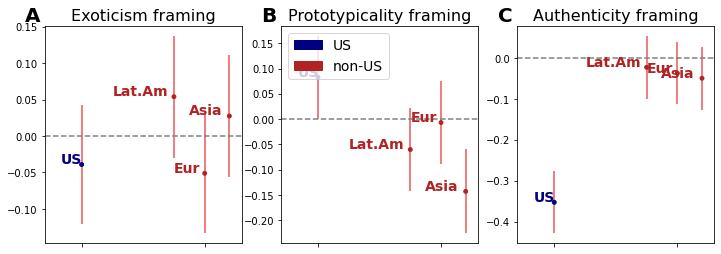

In [35]:
# Study 1 main results

fig_name = 'gpt_study1_main_results' # set name without file extension
assert type(fig_name) == str
print("Will save figure to:", os.path.join(FIGURES_DIR, f"{fig_name}.pdf"))

dep_vars_to_plot = ['exotic_words_agg_score',
                    'typic_words_agg_score',
                    'auth_words_agg_score']

fig, axs = plt.subplots(1,3,figsize=(12,4),sharey=False,sharex=True)

macro_coeff_ticks = ['us','non-us']
pretty_macro_coeff_ticks = ['US','non-US']
region_coeff_ticks = ['us','europe','latin_america','asia']
pretty_region_coeff_ticks = ['US','Eur','Lat.Am','Asia']

coeff2x_val = {
    'exotic_words_agg_score': {'us': 0, 'europe': 1, 'latin_america':1-0.25, 'asia':1+0.2},
    'auth_words_agg_score': {'us': 0, 'europe': 1, 'latin_america':1-0.25, 'asia':1+0.2},
    'typic_words_agg_score': {'us': 0, 'europe': 1, 'latin_america':1-0.25, 'asia':1+0.2},}

for ax_ix,dep_var in enumerate(dep_vars_to_plot):

    # get results from .csvs
    res = fetch_results(dep_var, 'biz_cuisine_region', results_dir='llm_results')
    covar_res = fetch_results(dep_var, 'biz_cuisine_region', covars=True, results_dir='llm_results')
    per_region_coeffs = get_abs_coeffs(res, per_cuisine=False)
    per_region_errs = get_abs_errs(res, covar_res, per_cuisine=False)

    # Overall parameters
    ax = axs[ax_ix]
    ax.axhline(y=0, color="gray", linestyle="--")
    ax.set_xticks(range(len(macro_coeff_ticks)))
    ax.set_xticklabels([])
    ax.set_xlim(-0.3,1.3)
    
#     if ax_ix < 2:
#         ax.set_ylim(-.07,.07)
#     else:
#         ax.set_ylim(-.21,.21)

    # Plot coefficients
    ax.scatter([coeff2x_val[dep_var][x] for x in region_coeff_ticks],
               [per_region_coeffs[x] for x in region_coeff_ticks], 
               color=[cont2color[cuisine2macro_region[x]] for x in region_coeff_ticks], 
               zorder=2,s=15)

    # Plot errors
    for idx, coeff in enumerate(region_coeff_ticks):
        color = "lightcoral" #if pvals[coeff] < 0.05 else 'lightgray'
        ax.vlines(coeff2x_val[dep_var][coeff], 
                  per_region_coeffs[coeff]-2*per_region_errs[coeff], 
                  per_region_coeffs[coeff]+2*per_region_errs[coeff], 
                  color=color, 
                  zorder=1, linewidth=2)

    # Add labels
    for idx, coeff in enumerate(region_coeff_ticks):
        offset = len(pretty_region_coeff_ticks[idx])*.083
        ax.annotate(pretty_region_coeff_ticks[idx], 
                    (coeff2x_val[dep_var][coeff]-offset, per_region_coeffs[coeff]+0.002), 
                    color=cont2color[cuisine2macro_region[coeff]],
                    fontsize=14, weight="bold")

    # Add titles 
    ax.set_title(f"{prettify_dep_var(dep_var)} framing",fontsize=16)
    ax.text(-0.1, 1.02, string.ascii_uppercase[ax_ix], transform=ax.transAxes, 
            size=20, weight='bold')
    
    # Add legend to first subplot
    if ax_ix == 1:
        us_patch = mpatches.Patch(color=cont2color['us'], label='US')
        non_us_patch = mpatches.Patch(color=cont2color['non-us'], label='non-US')
        ax.legend(handles=[us_patch, non_us_patch], fontsize=14, loc='upper left')
    
#     # Save just the portion _inside_ the second axis's boundaries
#     extent = full_extent(ax).transformed(fig.dpi_scale_trans.inverted())
#     # Alternatively,
#     # extent = ax.get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
#     print("Saving subplot to:", os.path.join(FIGURES_DIR, f"{fig_name}_subplot{ax_ix}.pdf"))
#     fig.savefig(os.path.join(FIGURES_DIR, f"{fig_name}_subplot{ax_ix}.pdf"), bbox_inches=extent)
plt.savefig(os.path.join(FIGURES_DIR, f"{fig_name}.pdf"),bbox_inches="tight")
plt.show()

In [39]:
# Prestige results
res = fetch_results('filtered_liwc_posemo_agg_score', 'biz_cuisine_region', results_dir='llm_results')
display(res)
print(get_abs_coeffs(res, ref='europe'))
res = fetch_results('luxury_words_agg_score', 'biz_cuisine_region', results_dir='llm_results')
display(res)
print(get_abs_coeffs(res, ref='europe'))
res = fetch_results('hygiene_words_agg_score', 'biz_cuisine_region', results_dir='llm_results')
display(res)
print(get_abs_coeffs(res, ref='europe'))
res = fetch_results('hygiene_pos_words_agg_score', 'biz_cuisine_region', results_dir='llm_results')
display(res)
print(get_abs_coeffs(res, ref='europe'))
res = fetch_results('hygiene_neg_words_agg_score', 'biz_cuisine_region', results_dir='llm_results')
display(res)
print(get_abs_coeffs(res, ref='europe'))
res = fetch_results('cheapness_words_agg_score', 'biz_cuisine_region', results_dir='llm_results')
display(res)
print(get_abs_coeffs(res, ref='europe'))
res = fetch_results('cheapness_exp_words_agg_score', 'biz_cuisine_region', results_dir='llm_results')
display(res)
print(get_abs_coeffs(res, ref='europe'))
res = fetch_results('cheapness_cheap_words_agg_score', 'biz_cuisine_region', results_dir='llm_results')
display(res)
print(get_abs_coeffs(res, ref='europe'))

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1314,0.031,4.228,0.0,0.071,0.192
"C(biz_cuisine_region, Treatment(reference='europe'))[T.asia]",-0.2111,0.024,-8.673,0.0,-0.259,-0.163
"C(biz_cuisine_region, Treatment(reference='europe'))[T.latin_america]",-0.2591,0.024,-10.661,0.0,-0.307,-0.211
"C(biz_cuisine_region, Treatment(reference='europe'))[T.us]",-0.1963,0.024,-8.072,0.0,-0.244,-0.149
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Negative]",-0.9607,0.038,-25.572,0.0,-1.034,-0.887
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Positive]",0.3275,0.033,9.963,0.0,0.263,0.392
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Very negative]",-0.9949,0.038,-26.333,0.0,-1.069,-0.921
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Very positive]",0.3534,0.032,11.193,0.0,0.292,0.415
review_len,0.2404,0.010,24.649,0.0,0.221,0.259


{'asia': -0.07970000000000002, 'latin_america': -0.1277, 'us': -0.06490000000000001, 'europe': 0.1314}


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0172,0.040,0.432,0.666,-0.061,0.095
"C(biz_cuisine_region, Treatment(reference='europe'))[T.asia]",0.0426,0.031,1.368,0.171,-0.018,0.104
"C(biz_cuisine_region, Treatment(reference='europe'))[T.latin_america]",-0.1487,0.031,-4.780,0.000,-0.210,-0.088
"C(biz_cuisine_region, Treatment(reference='europe'))[T.us]",-0.0353,0.031,-1.134,0.257,-0.096,0.026
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Negative]",-0.2380,0.048,-4.950,0.000,-0.332,-0.144
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Positive]",0.0857,0.042,2.037,0.042,0.003,0.168
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Very negative]",-0.2019,0.048,-4.175,0.000,-0.297,-0.107
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Very positive]",0.0961,0.040,2.378,0.017,0.017,0.175
review_len,0.2046,0.012,16.391,0.000,0.180,0.229


{'asia': 0.0598, 'latin_america': -0.1315, 'us': -0.018099999999999998, 'europe': 0.0172}


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1753,0.041,-4.254,0.000,-0.256,-0.095
"C(biz_cuisine_region, Treatment(reference='europe'))[T.asia]",0.2165,0.032,6.710,0.000,0.153,0.280
"C(biz_cuisine_region, Treatment(reference='europe'))[T.latin_america]",0.0359,0.032,1.113,0.266,-0.027,0.099
"C(biz_cuisine_region, Treatment(reference='europe'))[T.us]",0.0768,0.032,2.381,0.017,0.014,0.140
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Negative]",0.1183,0.050,2.375,0.018,0.021,0.216
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Positive]",0.0381,0.044,0.874,0.382,-0.047,0.124
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Very negative]",0.3726,0.050,7.439,0.000,0.274,0.471
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Very positive]",0.0754,0.042,1.801,0.072,-0.007,0.157
review_len,0.0303,0.013,2.346,0.019,0.005,0.056


{'asia': 0.04119999999999999, 'latin_america': -0.13940000000000002, 'us': -0.09850000000000002, 'europe': -0.1753}


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1469,0.041,-3.561,0.000,-0.228,-0.066
"C(biz_cuisine_region, Treatment(reference='europe'))[T.asia]",0.2332,0.032,7.219,0.000,0.170,0.297
"C(biz_cuisine_region, Treatment(reference='europe'))[T.latin_america]",0.0607,0.032,1.882,0.060,-0.003,0.124
"C(biz_cuisine_region, Treatment(reference='europe'))[T.us]",0.0337,0.032,1.045,0.296,-0.030,0.097
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Negative]",-0.0064,0.050,-0.129,0.898,-0.104,0.091
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Positive]",0.0550,0.044,1.260,0.208,-0.031,0.141
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Very negative]",-0.0132,0.050,-0.262,0.793,-0.111,0.085
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Very positive]",0.1211,0.042,2.888,0.004,0.039,0.203
review_len,0.0206,0.013,1.593,0.111,-0.005,0.046


{'asia': 0.08629999999999999, 'latin_america': -0.0862, 'us': -0.1132, 'europe': -0.1469}


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.0983,0.041,-2.403,0.016,-0.178,-0.018
"C(biz_cuisine_region, Treatment(reference='europe'))[T.asia]",0.0657,0.032,2.050,0.040,0.003,0.128
"C(biz_cuisine_region, Treatment(reference='europe'))[T.latin_america]",-0.0129,0.032,-0.403,0.687,-0.076,0.050
"C(biz_cuisine_region, Treatment(reference='europe'))[T.us]",0.0760,0.032,2.375,0.018,0.013,0.139
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Negative]",0.1800,0.049,3.642,0.000,0.083,0.277
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Positive]",-0.0034,0.043,-0.079,0.937,-0.088,0.081
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Very negative]",0.5595,0.050,11.254,0.000,0.462,0.657
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Very positive]",-0.0201,0.042,-0.483,0.629,-0.101,0.061
review_len,0.0222,0.013,1.727,0.084,-0.003,0.047


{'asia': -0.032600000000000004, 'latin_america': -0.1112, 'us': -0.0223, 'europe': -0.0983}


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.0999,0.040,-2.471,0.014,-0.179,-0.021
"C(biz_cuisine_region, Treatment(reference='europe'))[T.asia]",-0.0061,0.032,-0.192,0.848,-0.068,0.056
"C(biz_cuisine_region, Treatment(reference='europe'))[T.latin_america]",-0.0113,0.032,-0.357,0.721,-0.073,0.051
"C(biz_cuisine_region, Treatment(reference='europe'))[T.us]",-0.0686,0.032,-2.167,0.030,-0.131,-0.007
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Negative]",0.4363,0.049,8.923,0.000,0.340,0.532
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Positive]",0.0409,0.043,0.956,0.339,-0.043,0.125
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Very negative]",0.4160,0.049,8.462,0.000,0.320,0.512
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Very positive]",0.0528,0.041,1.284,0.199,-0.028,0.133
review_len,-0.1272,0.013,-10.027,0.000,-0.152,-0.102


{'asia': -0.106, 'latin_america': -0.11120000000000001, 'us': -0.16849999999999998, 'europe': -0.0999}


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.0646,0.039,-1.638,0.101,-0.142,0.013
"C(biz_cuisine_region, Treatment(reference='europe'))[T.asia]",-0.0831,0.031,-2.693,0.007,-0.144,-0.023
"C(biz_cuisine_region, Treatment(reference='europe'))[T.latin_america]",-0.0299,0.031,-0.969,0.333,-0.090,0.031
"C(biz_cuisine_region, Treatment(reference='europe'))[T.us]",-0.0391,0.031,-1.267,0.205,-0.100,0.021
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Negative]",0.5964,0.048,12.513,0.000,0.503,0.690
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Positive]",-0.0283,0.042,-0.678,0.498,-0.110,0.053
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Very negative]",0.6057,0.048,12.637,0.000,0.512,0.700
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Very positive]",-0.0328,0.040,-0.818,0.414,-0.111,0.046
review_len,-0.1134,0.012,-9.166,0.000,-0.138,-0.089


{'asia': -0.1477, 'latin_america': -0.0945, 'us': -0.10370000000000001, 'europe': -0.0646}


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.0752,0.041,-1.819,0.069,-0.156,0.006
"C(biz_cuisine_region, Treatment(reference='europe'))[T.asia]",0.0951,0.032,2.937,0.003,0.032,0.159
"C(biz_cuisine_region, Treatment(reference='europe'))[T.latin_america]",0.0199,0.032,0.616,0.538,-0.043,0.083
"C(biz_cuisine_region, Treatment(reference='europe'))[T.us]",-0.0582,0.032,-1.799,0.072,-0.122,0.005
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Negative]",-0.0672,0.050,-1.346,0.178,-0.165,0.031
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Positive]",0.0996,0.044,2.278,0.023,0.014,0.185
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Very negative]",-0.1106,0.050,-2.201,0.028,-0.209,-0.012
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Very positive]",0.1239,0.042,2.949,0.003,0.042,0.206
review_len,-0.0566,0.013,-4.361,0.000,-0.082,-0.031


{'asia': 0.0199, 'latin_america': -0.0553, 'us': -0.13340000000000002, 'europe': -0.0752}


Will save figure to: figs/study2_main_results_llm.pdf


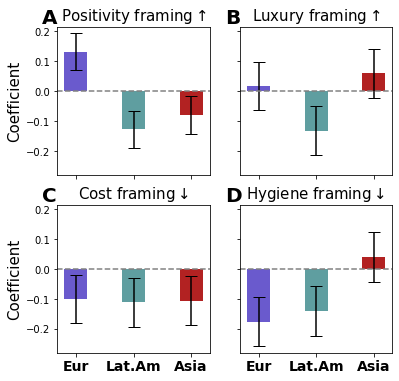

In [37]:
# Study 2 main results

fig_name = 'study2_main_results_llm' # set name without file extension
assert type(fig_name) == str
print("Will save figure to:", os.path.join(FIGURES_DIR, f"{fig_name}.pdf"))

dep_vars_to_plot = ['filtered_liwc_posemo_agg_score',
                    'luxury_words_agg_score',
                    'cheapness_words_agg_score',
                    'hygiene_words_agg_score']

fig, axs = plt.subplots(2,2,figsize=(6,6),sharey=True,sharex=True)

region_coeff_ticks = ['europe','latin_america','asia']
pretty_region_coeff_ticks = ['Eur','Lat.Am','Asia']

for ax_ix,dep_var in enumerate(dep_vars_to_plot):

    # get results from .csvs
    res = fetch_results(dep_var, 'biz_cuisine_region', results_dir='llm_results')
    covar_res = fetch_results(dep_var, 'biz_cuisine_region', covars=True, results_dir='llm_results')
    per_region_coeffs = get_abs_coeffs(res, ref='europe', per_cuisine=False)
    per_region_errs = get_abs_errs(res, covar_res, ref='europe', per_cuisine=False)

    # Overall parameters
    ax = axs[int(ax_ix/2)][ax_ix%2]
    ax.axhline(y=0, color="gray", linestyle="--")
    ax.set_xticks(range(len(region_coeff_ticks)))
    ax.set_xticklabels(pretty_region_coeff_ticks, fontweight='bold', fontsize=14)

    # Plot coefficients
    ax.bar(range(len(region_coeff_ticks)),
           [per_region_coeffs[x] for x in region_coeff_ticks],
           width=0.4,
           yerr=[2*per_region_errs[x] for x in region_coeff_ticks],
           capsize=6,
           color=[cont2color[x] for x in region_coeff_ticks], 
           zorder=1)
        
    # Add titles 
    if ax_ix < 2:
        ax.set_title(f"{prettify_dep_var(dep_var)} framing"+r'$\uparrow$',fontsize=15)
    else:
        ax.set_title(f"{prettify_dep_var(dep_var)} framing"+r'$\downarrow$',fontsize=15)
    ax.text(-0.1, 1.02, string.ascii_uppercase[ax_ix], transform=ax.transAxes, 
            size=20, weight='bold')
    
    if ax_ix % 2 == 0:
        ax.set_ylabel("Coefficient", fontsize=15)
        
#     # Save just the portion _inside_ the second axis's boundaries
#     extent = full_extent(ax).transformed(fig.dpi_scale_trans.inverted())
#     # Alternatively,
#     # extent = ax.get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
#     print("Saving subplot to:", os.path.join(FIGURES_DIR, f"{fig_name}_subplot{ax_ix}.pdf"))
#     fig.savefig(os.path.join(FIGURES_DIR, f"{fig_name}_subplot{ax_ix}.pdf"), bbox_inches=extent)
    
plt.savefig(os.path.join(FIGURES_DIR, f"{fig_name}.pdf"),bbox_inches="tight")
plt.show()

In [38]:
# Rusticity results
res = fetch_results('auth_simple_words_agg_score', 'biz_cuisine_region', results_dir='llm_results')
display(res)
print(get_abs_coeffs(res))

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0657,0.041,1.611,0.107,-0.014,0.146
"C(biz_cuisine_region, Treatment(reference='us'))[T.asia]",-0.2789,0.032,-8.663,0.000,-0.342,-0.216
"C(biz_cuisine_region, Treatment(reference='us'))[T.europe]",-0.0837,0.032,-2.616,0.009,-0.146,-0.021
"C(biz_cuisine_region, Treatment(reference='us'))[T.latin_america]",-0.1390,0.032,-4.332,0.000,-0.202,-0.076
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Negative]",-0.0699,0.049,-1.413,0.158,-0.167,0.027
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Positive]",0.0764,0.043,1.765,0.078,-0.008,0.161
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Very negative]",-0.0473,0.050,-0.951,0.342,-0.145,0.050
"C(biz_sentiment, Treatment(reference='Neutral'))[T.Very positive]",0.1199,0.042,2.885,0.004,0.038,0.201
review_len,0.1071,0.013,8.340,0.000,0.082,0.132


{'asia': -0.2132, 'europe': -0.018000000000000002, 'latin_america': -0.07330000000000002, 'us': 0.0657}
